# **Data Explorattion**

**Mục tiêu**:

- Hiểu cấu trúc dữ liệu: số dòng, số cột, danh sách và ý nghĩa các features.
- Đánh giá chất lượng dữ liệu: missing, invalid, cardinality, outliers.
- Phân tích phân phối của từng feature (numeric & categorical).
- Phân tích mối quan hệ giữa feature với nhau và với biến mục tiêu `target`.
- Rút ra các insight & câu hỏi nghiên cứu để chuẩn bị cho preprocessing và modeling.

## Import thư viện

In [1]:
import os
import sys
import numpy as np

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.visualization import (
    plot_missing_bar,
    plot_outliers,
    plot_target_distribution,
    plot_numeric_distribution,
    plot_ecdf,
    plot_categorical_distribution,
    plot_pie,
    plot_target_rate_by_category,
    boxplot_numeric_by_target,
    plot_hist_overlay_by_target,
    plot_scatter,
    plot_scatter_matrix,
    plot_correlation_heatmap,
    plot_line,
    visualize_q1_risk_profiles,
    visualize_q2_training_hours_effect,
    visualize_q3_exp_cdi_interaction,
    visualize_q4_career_trajectories,
    visualize_q5_missing_patterns,
    visualize_q6_risk_buckets,
)

# Để xem số liệu rõ ràng hơn
np.set_printoptions(suppress=True)

## I. Chuẩn bị dữ liệu & Thông tin tổng quan

**Ở phần này sẽ thực hiện các công việc sau:**

- Load file CSV vào NumPy.
- Tách header và data.
- In ra số dòng, số cột.
- Liệt kê danh sách các feature.

### Load dữ liệu

In [2]:
DATA_PATH = os.path.join(PROJECT_ROOT, "data", "raw", "aug_train.csv")

with open(DATA_PATH, "r", encoding="utf-8") as f:
    header = f.readline().strip().split(",")

data = np.genfromtxt(
    DATA_PATH,
    delimiter=",",
    dtype=str,
    skip_header=1
)

print("Xem thử 5 dòng đầu của bộ dữ liệu:")
for i in range(5):
    print(data[i])

Xem thử 5 dòng đầu của bộ dữ liệu:
['8949' 'city_103' '0.92' 'Male' 'Has relevent experience' 'no_enrollment'
 'Graduate' 'STEM' '>20' '' '' '1' '36' '1.0']
['29725' 'city_40' '0.7759999999999999' 'Male' 'No relevent experience'
 'no_enrollment' 'Graduate' 'STEM' '15' '50-99' 'Pvt Ltd' '>4' '47' '0.0']
['11561' 'city_21' '0.624' '' 'No relevent experience' 'Full time course'
 'Graduate' 'STEM' '5' '' '' 'never' '83' '0.0']
['33241' 'city_115' '0.789' '' 'No relevent experience' '' 'Graduate'
 'Business Degree' '<1' '' 'Pvt Ltd' 'never' '52' '1.0']
['666' 'city_162' '0.767' 'Male' 'Has relevent experience' 'no_enrollment'
 'Masters' 'STEM' '>20' '50-99' 'Funded Startup' '4' '8' '0.0']


### Thông tin tổng quan

In [3]:
DATA_PATH = os.path.join(PROJECT_ROOT, "data", "raw", "aug_train.csv")

with open(DATA_PATH, "r", encoding="utf-8") as f:
    header = f.readline().strip().split(",")

data = np.genfromtxt(
    DATA_PATH,
    delimiter=",",
    dtype=str,
    skip_header=1,
    encoding="utf-8",
)

num_rows, num_cols = data.shape

print(f"Số dòng (samples): {num_rows}")
print(f"Số cột (features): {num_cols}\n")

print("Danh sách features:")
for i, col in enumerate(header):
    print(f"{i:2d}. {col}")

Số dòng (samples): 19158
Số cột (features): 14

Danh sách features:
 0. enrollee_id
 1. city
 2. city_development_index
 3. gender
 4. relevent_experience
 5. enrolled_university
 6. education_level
 7. major_discipline
 8. experience
 9. company_size
10. company_type
11. last_new_job
12. training_hours
13. target


#### Ý nghĩa của các features
- **enrollee_id** — ID ứng viên (unique identifier).
- **city** — mã thành phố ứng viên sinh sống.
- **city_development_index** — mức độ phát triển của thành phố (0–1).
- **gender** — giới tính của ứng viên.
- **relevent_experience** — ứng viên có kinh nghiệm liên quan hay không.
- **enrolled_university** — ứng viên đang theo học loại chương trình đại học nào.
- **education_level** — trình độ học vấn cao nhất.
- **major_discipline** — chuyên ngành học.
- **experience** — số năm kinh nghiệm làm việc.
- **company_size** — quy mô công ty nơi ứng viên làm việc.
- **company_type** — loại hình doanh nghiệp.
- **last_new_job** — số năm kể từ công việc trước.
- **training_hours** — số giờ đào tạo đã hoàn thành.
- **target** — 1 nếu ứng viên muốn đổi việc; 0 nếu không.

## II. Tổng quan về các đặc trưng của bộ dữ liệu

**Phần này sẽ thực hiện các nhiệm vụ sau:**
- Kiểm tra duplicate rows cũng như duplicate IDs
- Ước lượng kiểu dữ liệu hiện tại cho từng cột: Numeric vs Categorical.
- Tính số lượng giá trị khác nhau cho từng cột.
- Đếm số lượng missing values ở từng cột.
- Vẽ biểu đồ bar cho missing values (`plot_missing_bar`).
- Kiểm tra sơ bộ các giá trị không hợp lệ:
  - Numeric nhưng chứa text kỳ lạ (vd: `'??'`, `'unknown'`).

### Helper functions

In [4]:
MISSING_TOKENS = {"", "nan", "NaN", "NULL", "null", "NA", "?"}

def is_missing(x: str) -> bool:
    if x is None:
        return True
    x = str(x).strip()
    return x == "" or x in MISSING_TOKENS

def is_float(x: str) -> bool:
    try:
        float(x)
        return True
    except:
        return False

col_idx_map = {name: idx for idx, name in enumerate(header)}

def get_col(col_name: str) -> np.ndarray:
    return data[:, col_idx_map[col_name]]

### Kiểm tra duplicate rows & duplicate IDs

In [5]:
# Duplicate rows
rows_str = np.array(["||".join(row) for row in data])
unique_rows, counts_rows = np.unique(rows_str, return_counts=True)
num_dup_rows = np.sum(counts_rows > 1)
print("Số lượng dòng trùng nhau:", num_dup_rows)

# Duplicate enrollee_id
if "enrollee_id" in header:
    enrollee_ids = get_col("enrollee_id")
    unique_ids, counts_ids = np.unique(enrollee_ids, return_counts=True)
    num_dup_ids = np.sum(counts_ids > 1)
    print("Số enrollee_id bị trùng:", num_dup_ids)

Số lượng dòng trùng nhau: 0
Số enrollee_id bị trùng: 0


### Nhận dạng kiểu dữ liệu

In [6]:
numeric_cols_raw = []
categorical_cols_raw = []
cardinality = {}

for j in range(num_cols):
    col_name = header[j]
    col_data = data[:, j]
    non_missing = np.array([x for x in col_data if not is_missing(x)])

    if len(non_missing) > 0:
        cardinality[col_name] = len(np.unique(non_missing))
    else:
        cardinality[col_name] = 0

    if len(non_missing) == 0:
        categorical_cols_raw.append(col_name)
        continue

    sample_size = min(50, len(non_missing))
    sample = np.random.choice(non_missing, size=sample_size, replace=False)
    numeric_ratio = np.mean([is_float(x) for x in sample])

    if numeric_ratio > 0.6:
        numeric_cols_raw.append(col_name)
    else:
        categorical_cols_raw.append(col_name)

max_len = max(len("Tên cột"), max(len(col) for col in header))

print("=" * (max_len + 20))
print(f"{'Tên cột'.ljust(max_len)} | Kiểu dữ liệu")
print("-" * (max_len + 20))

for col in numeric_cols_raw:
    print(f"{col.ljust(max_len)} | Numeric")

for col in categorical_cols_raw:
    print(f"{col.ljust(max_len)} | Categorical")

print("=" * (max_len + 20))

Tên cột                | Kiểu dữ liệu
------------------------------------------
enrollee_id            | Numeric
city_development_index | Numeric
experience             | Numeric
last_new_job           | Numeric
training_hours         | Numeric
target                 | Numeric
city                   | Categorical
gender                 | Categorical
relevent_experience    | Categorical
enrolled_university    | Categorical
education_level        | Categorical
major_discipline       | Categorical
company_size           | Categorical
company_type           | Categorical


### Số lượng các giá trị khác nhau (Unique value)

In [7]:
print("Số lượng các giá trị khác nhau cho từng feature (unique value):")
for name in header:
    print(f"{name:30s}: {cardinality[name]}")

Số lượng các giá trị khác nhau cho từng feature (unique value):
enrollee_id                   : 19158
city                          : 123
city_development_index        : 93
gender                        : 3
relevent_experience           : 2
enrolled_university           : 3
education_level               : 5
major_discipline              : 6
experience                    : 22
company_size                  : 8
company_type                  : 6
last_new_job                  : 6
training_hours                : 241
target                        : 2


### Kiểm tra missing values

In [8]:
missing_counts = np.zeros(num_cols, dtype=int)

for j in range(num_cols):
    col_data = data[:, j]
    missing_counts[j] = np.sum([is_missing(x) for x in col_data])

missing_ratios = missing_counts / num_rows

col_width_name = max(max(len(name) for name in header), len("Feature"))
col_width_cnt = max(max(len(str(c)) for c in missing_counts), len("Missing"))
col_width_ratio = len("Ratio")

print("=" * (col_width_name + col_width_cnt + col_width_ratio + 10))
print(f"{'Feature'.ljust(col_width_name)} | "
      f"{'Missing'.rjust(col_width_cnt)} | "
      f"{'Ratio'}")
print("-" * (col_width_name + col_width_cnt + col_width_ratio + 10))

for name, cnt, ratio in zip(header, missing_counts, missing_ratios):
    print(f"{name.ljust(col_width_name)} | "
          f"{str(cnt).rjust(col_width_cnt)} | "
          f"{ratio:6.3f}")

print("=" * (col_width_name + col_width_cnt + col_width_ratio + 10))

Feature                | Missing | Ratio
--------------------------------------------
enrollee_id            |       0 |  0.000
city                   |       0 |  0.000
city_development_index |       0 |  0.000
gender                 |    4508 |  0.235
relevent_experience    |       0 |  0.000
enrolled_university    |     386 |  0.020
education_level        |     460 |  0.024
major_discipline       |    2813 |  0.147
experience             |      65 |  0.003
company_size           |    5938 |  0.310
company_type           |    6140 |  0.320
last_new_job           |     423 |  0.022
training_hours         |       0 |  0.000
target                 |       0 |  0.000


### Bar chart


Thống kê missing values:
enrollee_id               :      0
city                      :      0
city_development_index    :      0
gender                    :   4508
relevent_experience       :      0
enrolled_university       :    386
education_level           :    460
major_discipline          :   2813
experience                :     65
company_size              :   5938
company_type              :   6140
last_new_job              :    423
training_hours            :      0
target                    :      0
Tổng số missing: 20733



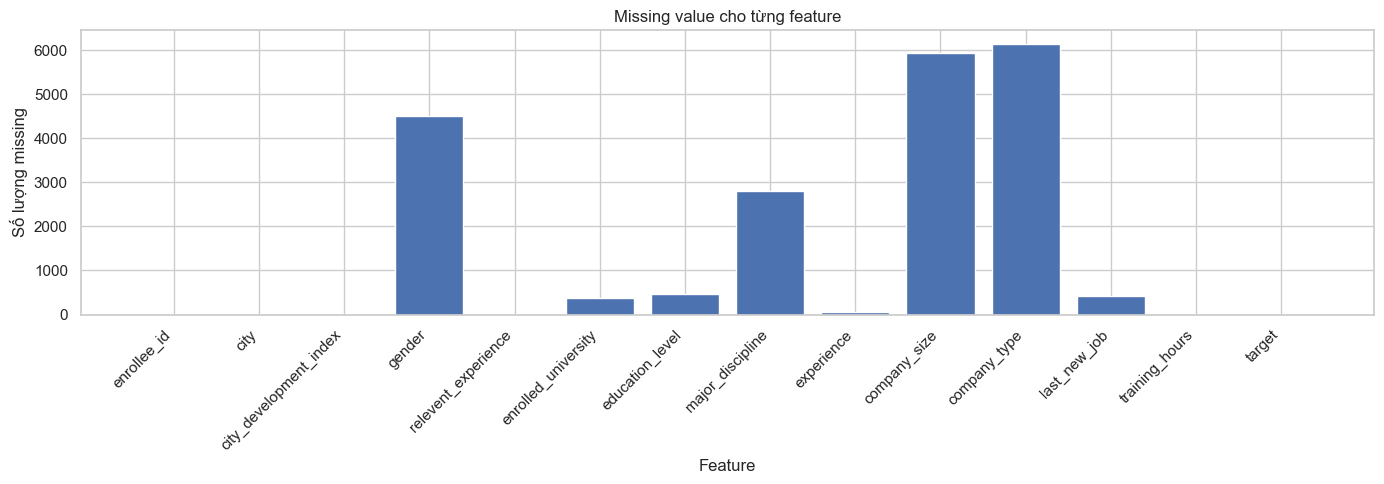

In [9]:
plot_missing_bar(header, missing_counts)

### Kiểm tra invalid values cho các cột kiểu numeric

In [10]:
print("Kiểm tra invalid value:")
is_invalid = False
for col_name in numeric_cols_raw:
    col = get_col(col_name)
    invalid_mask = [(not is_missing(x)) and (not is_float(x)) for x in col]
    invalid_vals = col[invalid_mask]
    if len(invalid_vals) > 0:
        is_invalid = True
        uniq, cnts = np.unique(invalid_vals, return_counts=True)
        print(f"\n[{col_name}] có giá trị không parse được sang float:")
        for u, c in zip(uniq, cnts):
            print(f"  '{u}' : {c} lần")
            
if is_invalid == False:
    print("Không tìm thấy.")

Kiểm tra invalid value:

[experience] có giá trị không parse được sang float:
  '<1' : 522 lần
  '>20' : 3286 lần

[last_new_job] có giá trị không parse được sang float:
  '>4' : 3290 lần
  'never' : 2452 lần


## II. Thống kê mô tả cho từng feature
**Mục tiêu của phần này:**

- Tóm tắt **hình dạng và phạm vi giá trị** của các biến trong dataset,
- Giúp ta có được cái nhìn tổng quan:
  - Numeric: giá trị nhỏ nhất, lớn nhất, trung bình, độ lệch chuẩn, và các phân vị (percentiles).
  - Categorical: có bao nhiêu loại giá trị khác nhau, những category nào xuất hiện nhiều nhất và chiếm tỷ lệ bao nhiêu.

Cụ thể:

#### 1. Đối với biến **numeric**

- Chuyển các cột số (đang đọc dưới dạng chuỗi) về dạng số thực (`float`), với:
  - Giá trị hợp lệ → số,
  - Giá trị không hợp lệ / thiếu → `NaN` (đã xử lý phần missing trước đó).
- Tính cho mỗi biến:
  - `min`, `max`
  - các phân vị: `5%`, `25%`, `50%` (median), `75%`, `95%`
  - `mean`, `std`
- Qua đó ta biết:
  - Biến nằm trong khoảng giá trị nào,
  - Có bị lệch mạnh không,
  - Có giá trị cực trị hay không.

#### 2. Đối với biến **categorical**
- Với từng cột:
  - Đếm số lượng category khác nhau,
  - Liệt kê **top-k category xuất hiện nhiều nhất**:
    - Số lần xuất hiện,
    - Tỷ lệ trên toàn bộ tập dữ liệu.
- Qua đó ta biết:
  - Biến có ít hay nhiều category (low/high cardinality),
  - Có bị **mất cân bằng mạnh** ở một vài category hay không,
  - Hỗ trợ quyết định cách encode (one-hot, gộp nhóm, v.v.) ở bước preprocessing.

---
### **Thống kê mô tả cho categorical**

In [11]:
def describe_categorical(col_name: str, top_k: int = 5):
    col = get_col(col_name)
    n_total = col.shape[0]
    
    non_missing = np.array([x for x in col if not is_missing(x)])
    n_non_missing = len(non_missing)
    
    print(f"Feature '{col_name}':")
    print(f"Tổng số giá trị hợp lệ (non-missing): {n_non_missing} / {n_total}")
    
    if n_non_missing == 0:
        print("-> Cột này không có giá trị hợp lệ để thống kê.")
        return
    
    # Phân phối category
    values, counts = np.unique(non_missing, return_counts=True)
    n_unique = len(values)
    print(f"Số lượng category khác nhau         : {n_unique}")
    
    # Sắp xếp giảm dần theo tần suất
    idx_sorted = np.argsort(-counts)
    values = values[idx_sorted]
    counts = counts[idx_sorted]
    
    # Tỷ lệ dựa trên toàn bộ số dòng (n_total) cho dễ so sánh với các biến khác
    ratios = counts / n_total
    
    k = min(top_k, n_unique)
    print(f"Top {k} category xuất hiện nhiều nhất:")
    print(f"{'Category':24s} | {'Count':>8s} | {'Ratio':>8s}")
    print("-" * 42)
    for v, c, r in zip(values[:k], counts[:k], ratios[:k]):
        print(f"{v:24s} | {c:8d} | {r:8.3f}")
    
    if n_unique > k:
        other_count = counts[k:].sum()
        other_ratio = other_count / n_total
        print("-" * 42)
        print(f"{'(others)':24s} | {other_count:8d} | {other_ratio:8.3f}")
    print("="*55)

In [12]:
categorical_to_describe = [
    "gender",
    "education_level",
    "major_discipline",
    "company_size",
    "company_type",
    "enrolled_university",
    "relevent_experience",
    "city",
]
print("="*55)
for col_name in categorical_to_describe:
    describe_categorical(col_name, top_k=3)

Feature 'gender':
Tổng số giá trị hợp lệ (non-missing): 14650 / 19158
Số lượng category khác nhau         : 3
Top 3 category xuất hiện nhiều nhất:
Category                 |    Count |    Ratio
------------------------------------------
Male                     |    13221 |    0.690
Female                   |     1238 |    0.065
Other                    |      191 |    0.010
Feature 'education_level':
Tổng số giá trị hợp lệ (non-missing): 18698 / 19158
Số lượng category khác nhau         : 5
Top 3 category xuất hiện nhiều nhất:
Category                 |    Count |    Ratio
------------------------------------------
Graduate                 |    11598 |    0.605
Masters                  |     4361 |    0.228
High School              |     2017 |    0.105
------------------------------------------
(others)                 |      722 |    0.038
Feature 'major_discipline':
Tổng số giá trị hợp lệ (non-missing): 16345 / 19158
Số lượng category khác nhau         : 6
Top 3 category xuất hiện 

### **Thống kê mô tả cho numeric**

Để có thể thống kê mô tả cho các biến numeric ở bộ dữ liệu này, ta cần **biến đổi giá trị của các cột sang dạng số**. Khi quan sát dữ liệu gốc, ta thấy:

- Một số cột **thực chất là số nhưng được lưu dưới dạng chuỗi** trong file CSV.
- Một số cột khác có **giá trị dạng text nhưng mang ý nghĩa thứ bậc (ordinal)**, hoàn toàn có thể ánh xạ về số.
- Nếu giữ nguyên dạng chuỗi, ta không thể:
  - Tính các thống kê như min, max, mean, percentiles,
  - Cũng như không thể vẽ đúng histogram, boxplot hoặc kiểm tra outlier.

Cụ thể trong bộ dữ liệu này, các cột được xử lý như numeric gồm:

1. **`city_development_index`**  
   - Giá trị đã là số thập phân, thường nằm trong khoảng từ 0 đến 1.  
   - Dữ liệu gốc được đọc lên dưới dạng chuỗi, nên ta cần chuyển toàn bộ về kiểu `float`.  
   - Các giá trị thiếu giữ nguyên dưới dạng `NaN`.  
   - Sau khi chuyển đổi, ta có thể:
     - Tính các thống kê cơ bản (min, max, mean, median, phân vị),
     - Vẽ histogram, boxplot,  
     - Kiểm tra phân bố và outlier.

2. **`training_hours`**  
   - Là số giờ training đã hoàn thành, giá trị là số nguyên không âm, nhưng trong file CSV vẫn được lưu dạng chuỗi.  
   - Ta chuyển toàn bộ sang dạng số thực (`float`) và gán `NaN` cho các giá trị thiếu.  
   - Điều này giúp ta:
     - Phân tích phân bố số giờ training (histogram, ECDF),
     - So sánh `training_hours` giữa nhóm đổi job và không đổi job,
     - Kiểm tra các giá trị bất thường (rất lớn hoặc bằng 0).

3. **`experience`**  
   - Cột này có giá trị dạng text như `"<1"`, `">20"`, `"5"`, `"10"`, …  
   - Nếu giữ nguyên chuỗi, ta **không thể thống kê trực tiếp**.  
   - Dựa trên ý nghĩa:
     - `"<1"` thể hiện kinh nghiệm dưới 1 năm → ánh xạ về một giá trị nhỏ, ví dụ **0.0** năm.
     - `">20"` thể hiện kinh nghiệm nhiều hơn 20 năm → ánh xạ về một giá trị đại diện, ví dụ **21.0** năm.
     - Các giá trị còn lại như `"5"`, `"10"` → chuyển thẳng sang số (`5.0`, `10.0`, …).  
   - Sau khi ánh xạ, `experience` trở thành một biến numeric biểu diễn **xấp xỉ số năm kinh nghiệm**, đủ tốt để:
     - Tính thống kê mô tả,
     - Vẽ biểu đồ phân bố,
     - Phân tích mối quan hệ giữa kinh nghiệm và khả năng đổi job.

4. **`last_new_job`**  
   - Đây là một biến thời gian mang tính **thứ bậc (ordinal)**, mô tả khoảng thời gian từ lần đổi việc gần nhất đến hiện tại.  
   - Giá trị gốc ở dạng chuỗi: `"never"`, `"1"`, `"2"`, `"3"`, `"4"`, `">4"`.  
   - Ta ánh xạ về số như sau:
     - `"never"`  → **0.0** (chưa từng đổi việc),
     - `"1"`      → **1.0** năm,
     - `"2"`      → **2.0** năm,
     - `"3"`      → **3.0** năm,
     - `"4"`      → **4.0** năm,
     - `">4"`     → **5.0** (đại diện cho “trên 4 năm”).  
   - Với cách ánh xạ này, ta có thể coi `last_new_job` như một biến numeric ordinal để:
     - Thống kê mô tả (min, max, median, phân vị),
     - So sánh phân bố `last_new_job` giữa nhóm đổi job và không đổi job,
     - Kết hợp trong các mô hình dự đoán như Logistic Regression.

5. **`target`**  
   - Là biến mục tiêu, với 2 giá trị:
     - `0` – **không** tìm kiếm việc làm / không muốn đổi job,
     - `1` – **đang** tìm kiếm việc làm / muốn đổi job.  
   - Dù được đọc lên dưới dạng chuỗi (`"0"`, `"1"`), bản chất đây là một biến nhị phân nên ta chuyển sang dạng số (`0.0`, `1.0`).  
   - Điều này giúp:
     - Đếm tần suất từng lớp và tính tỷ lệ mẫu thuộc mỗi lớp,
     - Dùng trực tiếp trong phân tích thống kê (so sánh theo nhóm `target`),
     - Chuẩn bị cho bước xây dựng mô hình phân loại ở các phần sau.


In [13]:
def parse_experience(x: str) -> float:
    if is_missing(x):
        return np.nan
    x = x.strip()
    if x.startswith("<"):
        return 0.0
    if x.startswith(">"):
        return 21.0
    if is_float(x):
        return float(x)
    return np.nan

def parse_last_new_job(x: str) -> float:
    if is_missing(x):
        return np.nan
    x = x.strip()

    if x == "never":
        return 0.0
    if x.startswith(">"):
        return 5.0  
    if is_float(x):
        return float(x)
    return np.nan

def parse_float_or_nan(x: str) -> float:
    return float(x) if (not is_missing(x) and is_float(x)) else np.nan

def get_numeric_array(col_name: str, parser=parse_float_or_nan):
    col = get_col(col_name)
    out = np.empty(col.shape[0], dtype=float)
    for i, v in enumerate(col):
        out[i] = parser(v)
    return out

In [14]:
cdi = get_numeric_array("city_development_index")
training_hours = get_numeric_array("training_hours")
experience = get_numeric_array("experience", parser=parse_experience)
target = get_numeric_array("target")
last_new_job = get_numeric_array("last_new_job", parser=parse_last_new_job)

numeric_arrays = {
    "city_development_index": cdi,
    "training_hours": training_hours,
    "experience": experience,
    "last_new_job": last_new_job,
}

header_fmt = (
    f"{'Feature':25s} | {'min':>8s} | {'5%':>8s} | {'25%':>8s} | {'50%':>8s} | "
    f"{'75%':>8s} | {'95%':>8s} | {'max':>8s} | {'mean':>8s} | {'std':>8s}"
)

print(header_fmt)
print("-" * len(header_fmt))

row_fmt = (
    "{name:25s} | {min:8.3f} | {p5:8.3f} | {p25:8.3f} | {p50:8.3f} | "
    "{p75:8.3f} | {p95:8.3f} | {max:8.3f} | {mean:8.3f} | {std:8.3f}"
)

for name, arr in numeric_arrays.items():
    x = arr[~np.isnan(arr)]
    if x.size == 0:
        continue

    q5, q25, q50, q75, q95 = np.percentile(x, [5, 25, 50, 75, 95])
    
    print(row_fmt.format(
        name=name,
        min=np.min(x),
        p5=q5,
        p25=q25,
        p50=q50,
        p75=q75,
        p95=q95,
        max=np.max(x),
        mean=np.mean(x),
        std=np.std(x, ddof=1)
    ))

Feature                   |      min |       5% |      25% |      50% |      75% |      95% |      max |     mean |      std
----------------------------------------------------------------------------------------------------------------------------
city_development_index    |    0.448 |    0.624 |    0.740 |    0.903 |    0.920 |    0.926 |    0.949 |    0.829 |    0.123
training_hours            |    1.000 |    7.000 |   23.000 |   47.000 |   88.000 |  188.000 |  336.000 |   65.367 |   60.058
experience                |    0.000 |    1.000 |    4.000 |    9.000 |   16.000 |   21.000 |   21.000 |   10.100 |    6.777
last_new_job              |    0.000 |    0.000 |    1.000 |    1.000 |    3.000 |    5.000 |    5.000 |    2.000 |    1.676


### Xác định Outliers cho numeric 
- Dùng phương pháp IQR (Q1, Q3, IQR) để xác định outlier:
  - `value < Q1 - 1.5 * IQR` hoặc `value > Q3 + 1.5 * IQR`.
- Đếm số lượng outliers ở mỗi feature numeric.

In [15]:
def detect_outliers_iqr(x):
    x = np.asarray(x, dtype=float)
    x_clean = x[~np.isnan(x)]
    if x_clean.size == 0:
        return np.zeros_like(x, dtype=bool)
    q1, q3 = np.percentile(x_clean, [25, 75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask_out = (x < lower) | (x > upper)
    return mask_out

print("    SỐ LƯỢNG OUTLIERS THEO TỪNG FEATURE (IQR)")
print("="*50)

header_fmt = f"{'Feature':25s} | {'Outliers':>10s}"
print(header_fmt)
print("-"*50)

row_fmt = "{name:25s} | {out:10d}"

for name, arr in numeric_arrays.items():
    mask_out = detect_outliers_iqr(arr)
    num_out = np.sum(mask_out & ~np.isnan(arr))
    print(row_fmt.format(name=name, out=num_out))

print("="*50)

    SỐ LƯỢNG OUTLIERS THEO TỪNG FEATURE (IQR)
Feature                   |   Outliers
--------------------------------------------------
city_development_index    |         17
training_hours            |        984
experience                |          0
last_new_job              |          0


#### Visualization

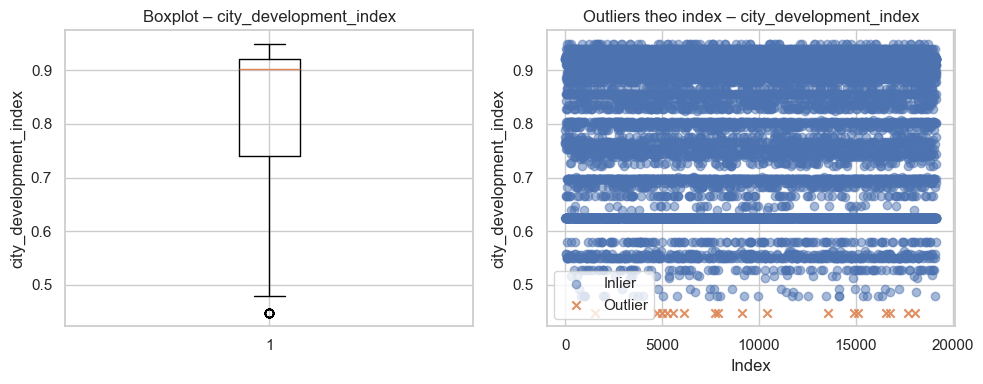

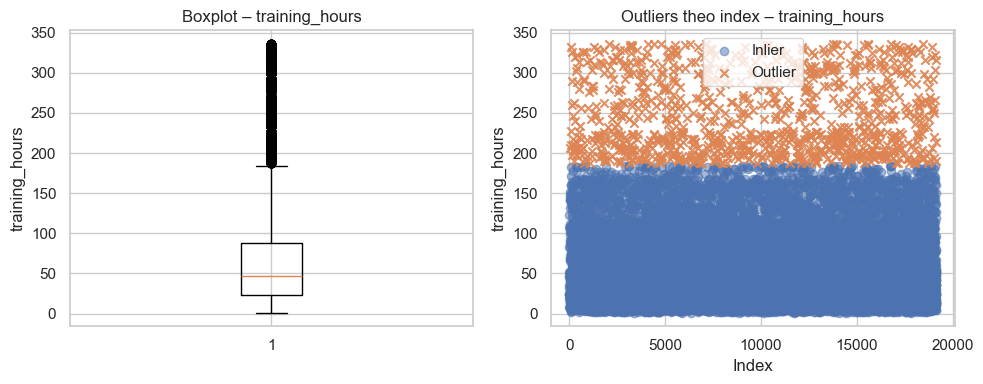

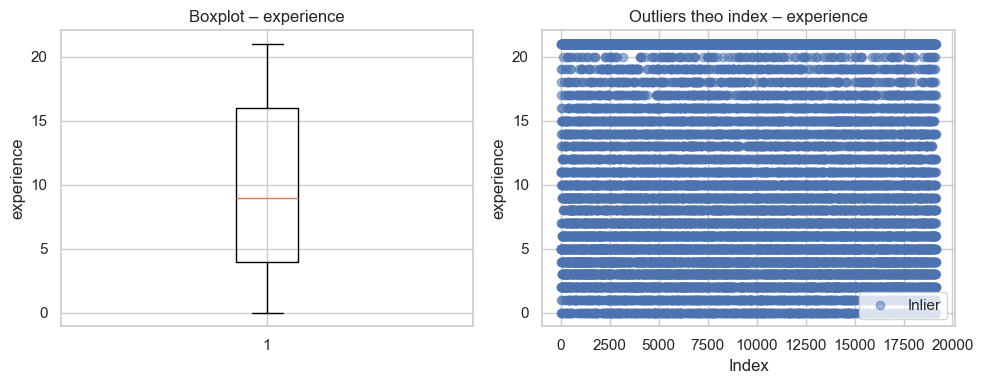

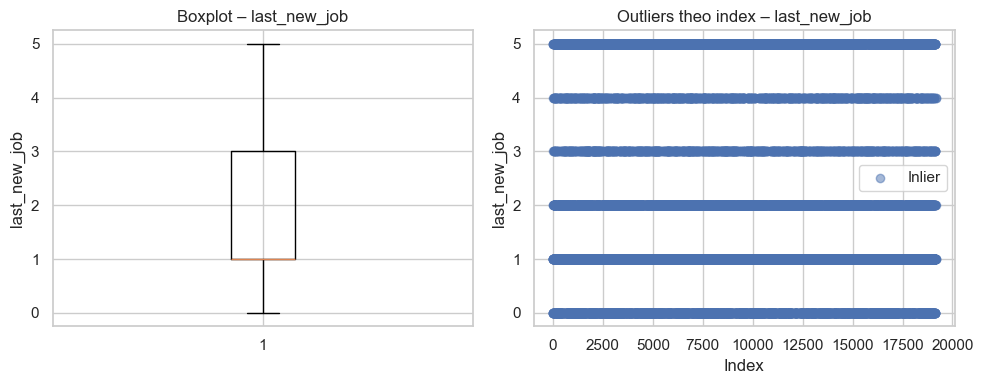

In [16]:
for name, arr in numeric_arrays.items():
    mask_out = detect_outliers_iqr(arr)
    plot_outliers(arr, mask_out, name)

## III. Phân phối của các feature
### Target


Phân phối target:
target=0 : 14381 mẫu (75.07%)
target=1 : 4777 mẫu (24.93%)



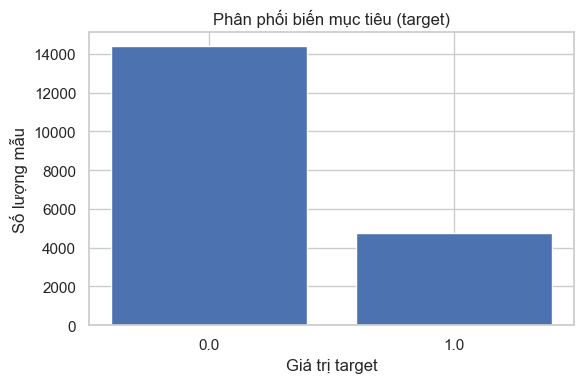

In [17]:
plot_target_distribution(target)

### Phân phối cho numeric

Ở phần này, ta quan sát phân phối của các feature dạng numeric bằng **Histogram**, **KDE** và **ECDF**.

- **Histogram**: cho thấy tần suất xuất hiện của giá trị trong từng khoảng → nhìn được độ lệch và dạng phân phối.  
- **KDE**: đường mật độ mượt giúp nhận biết xu hướng tổng thể và số lượng mode.  
- **ECDF**: biểu diễn tỷ lệ dữ liệu ≤ một giá trị → dễ thấy median, các bước nhảy và mức độ tích lũy.


Feature city_development_index:


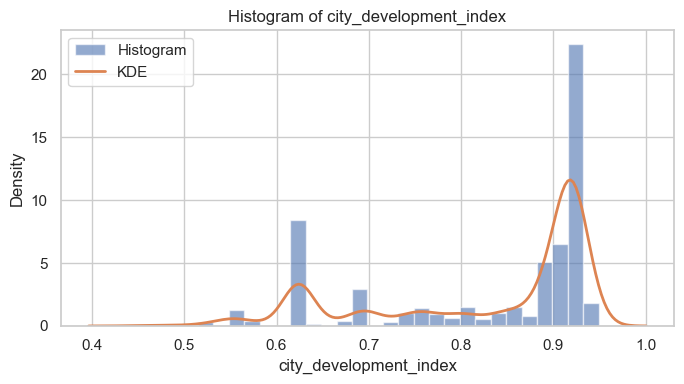

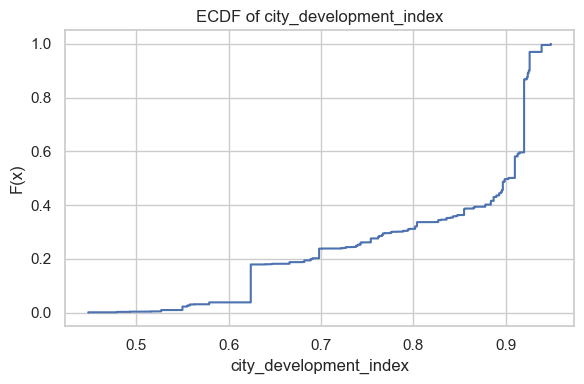

Feature training_hours:


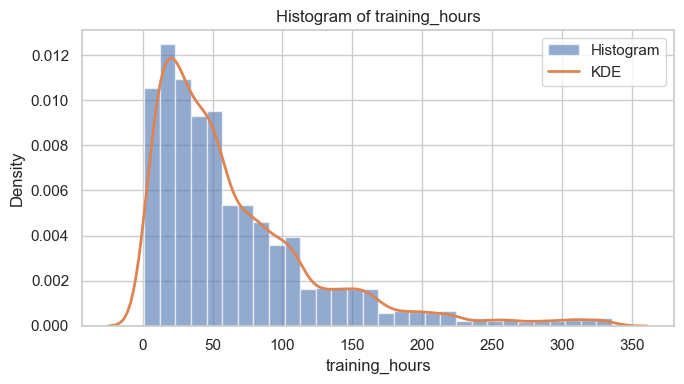

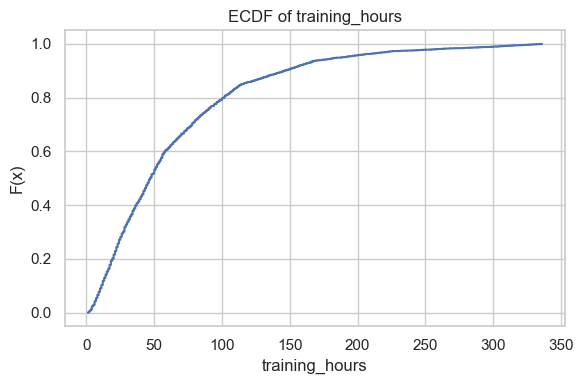

Feature experience:


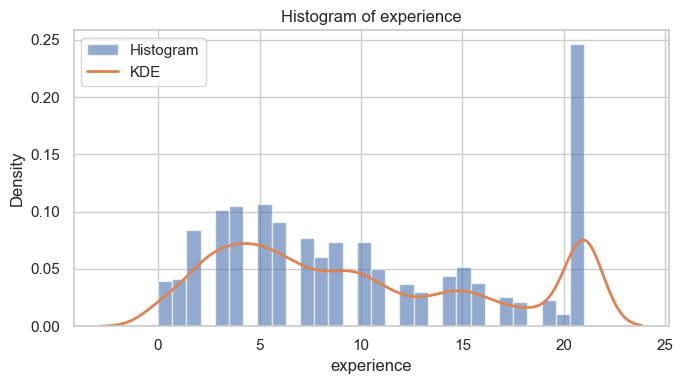

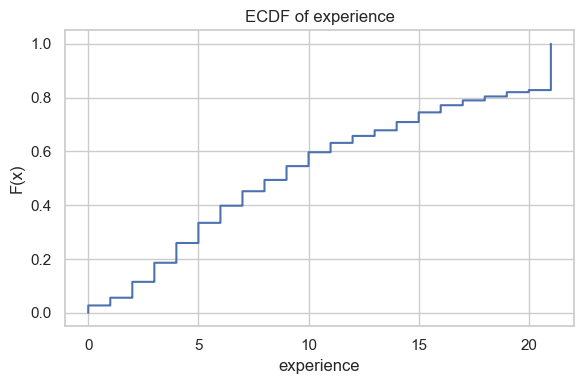

Feature last_new_job:


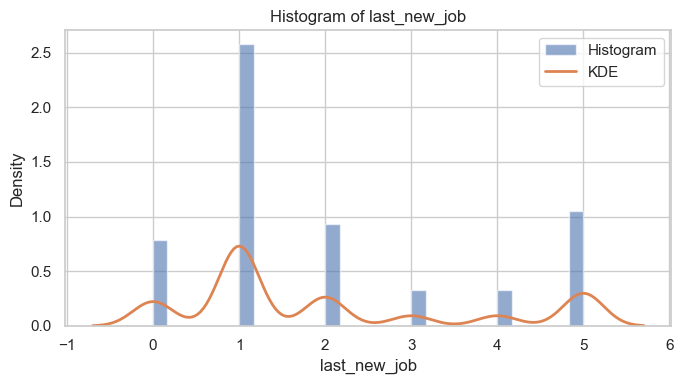

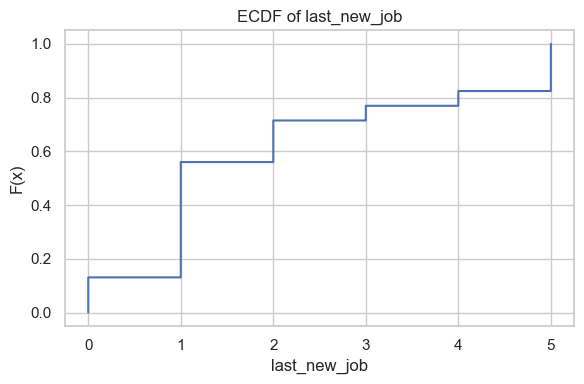

In [18]:
for name, arr in numeric_arrays.items():
    print(f"Feature {name}:")
    plot_numeric_distribution(arr, name, bins=30, show_kde=True, log_scale=False)
    plot_ecdf(arr, name)

### Phân phối các biến categorical

Ở phần này, ta trực quan hóa các feature dạng *categorical* bằng **biểu đồ bar** và **biểu đồ tròn (pie chart)**.

- **Bar chart**: cho thấy số lượng/tần suất từng category, dễ so sánh giữa các nhóm.  
- **Pie chart**: giúp quan sát tỷ lệ phần trăm của các nhóm chính, phù hợp khi chỉ xem top-k category.  
- Với các feature có quá nhiều giá trị (như `city`), ta chỉ xem **top 10** để biểu đồ rõ ràng hơn.



Thống kê categorical: gender:
Male                 :  13221 mẫu (69.01%)
MISSING              :   4508 mẫu (23.53%)
Female               :   1238 mẫu ( 6.46%)
Other                :    191 mẫu ( 1.00%)



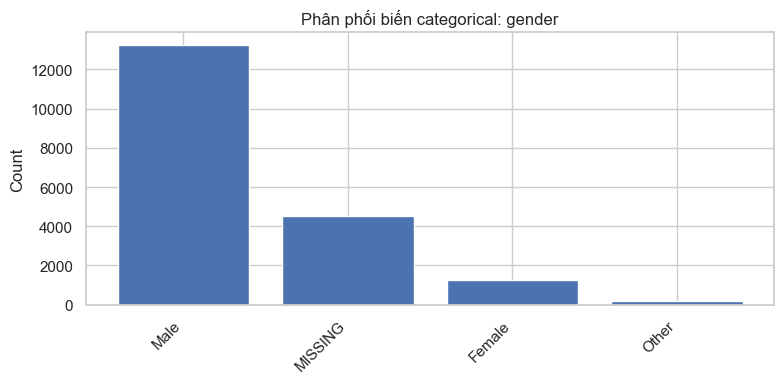


Pie chart stats: gender:
Male                 :  13221 mẫu (69.01%)
MISSING              :   4508 mẫu (23.53%)
Female               :   1238 mẫu ( 6.46%)
Other                :    191 mẫu ( 1.00%)



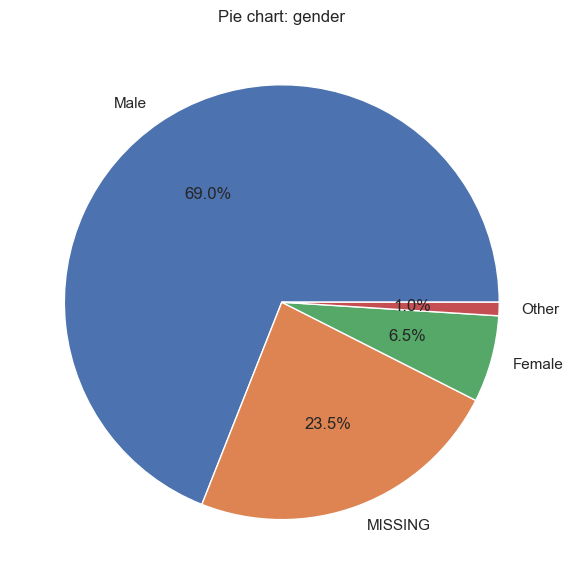


Thống kê categorical: education_level:
Graduate             :  11598 mẫu (60.54%)
Masters              :   4361 mẫu (22.76%)
High School          :   2017 mẫu (10.53%)
MISSING              :    460 mẫu ( 2.40%)
Phd                  :    414 mẫu ( 2.16%)
Primary School       :    308 mẫu ( 1.61%)



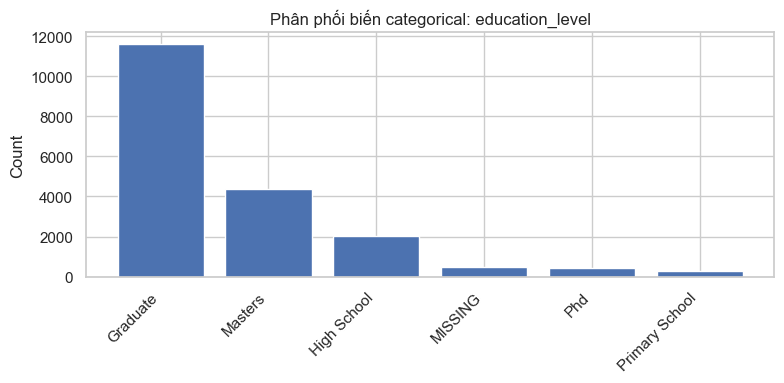


Pie chart stats: education_level:
Graduate             :  11598 mẫu (61.53%)
Masters              :   4361 mẫu (23.14%)
High School          :   2017 mẫu (10.70%)
MISSING              :    460 mẫu ( 2.44%)
Phd                  :    414 mẫu ( 2.20%)



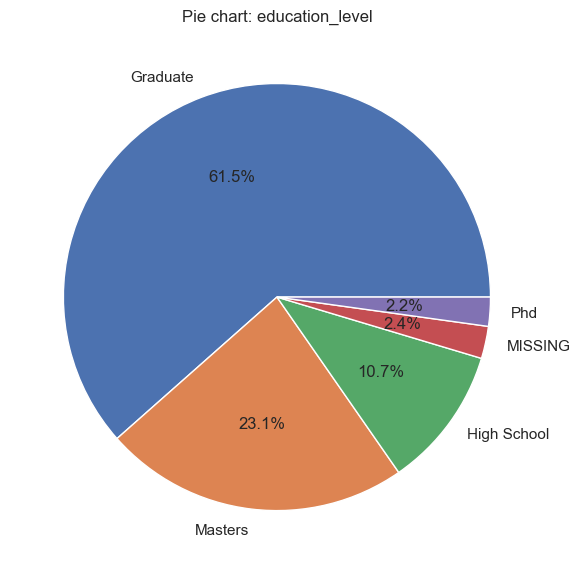


Thống kê categorical: major_discipline:
STEM                 :  14492 mẫu (75.64%)
MISSING              :   2813 mẫu (14.68%)
Humanities           :    669 mẫu ( 3.49%)
Other                :    381 mẫu ( 1.99%)
Business Degree      :    327 mẫu ( 1.71%)
Arts                 :    253 mẫu ( 1.32%)
No Major             :    223 mẫu ( 1.16%)



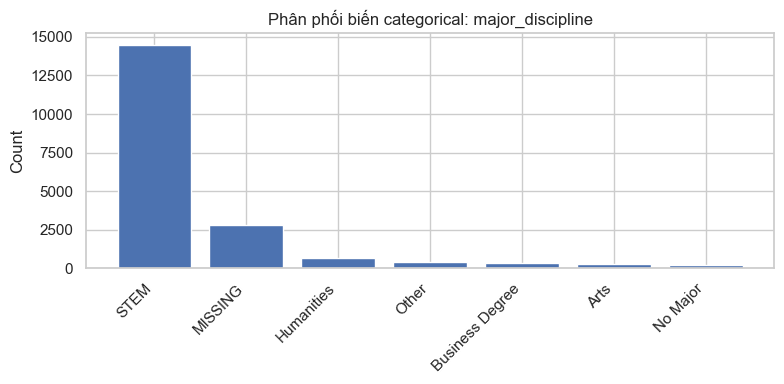


Pie chart stats: major_discipline:
STEM                 :  14492 mẫu (77.57%)
MISSING              :   2813 mẫu (15.06%)
Humanities           :    669 mẫu ( 3.58%)
Other                :    381 mẫu ( 2.04%)
Business Degree      :    327 mẫu ( 1.75%)



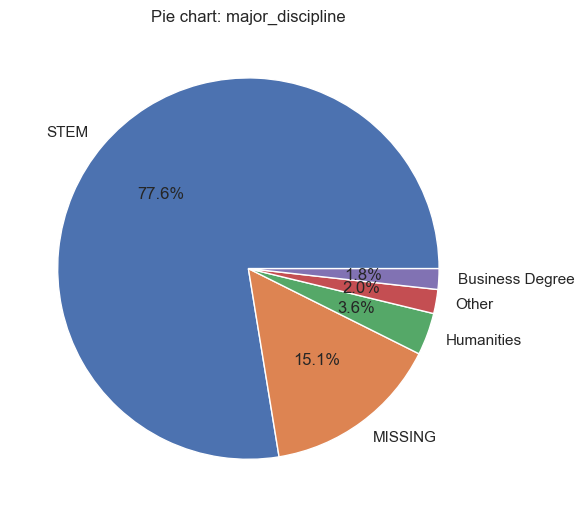


Thống kê categorical: company_size:
MISSING              :   5938 mẫu (30.99%)
50-99                :   3083 mẫu (16.09%)
100-500              :   2571 mẫu (13.42%)
10000+               :   2019 mẫu (10.54%)
10/49                :   1471 mẫu ( 7.68%)
1000-4999            :   1328 mẫu ( 6.93%)
<10                  :   1308 mẫu ( 6.83%)
500-999              :    877 mẫu ( 4.58%)
5000-9999            :    563 mẫu ( 2.94%)



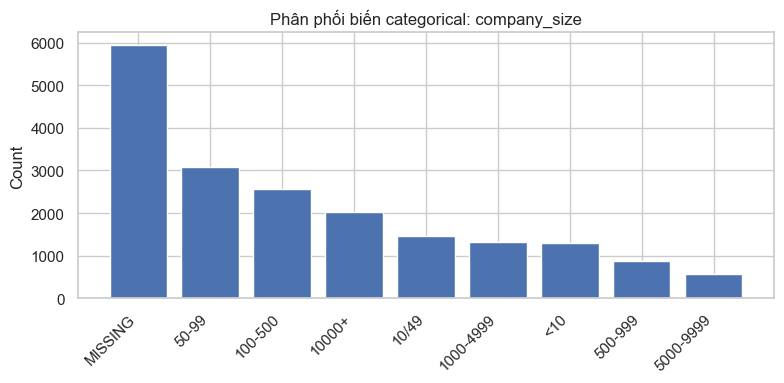


Pie chart stats: company_size:
MISSING              :   5938 mẫu (39.37%)
50-99                :   3083 mẫu (20.44%)
100-500              :   2571 mẫu (17.05%)
10000+               :   2019 mẫu (13.39%)
10/49                :   1471 mẫu ( 9.75%)



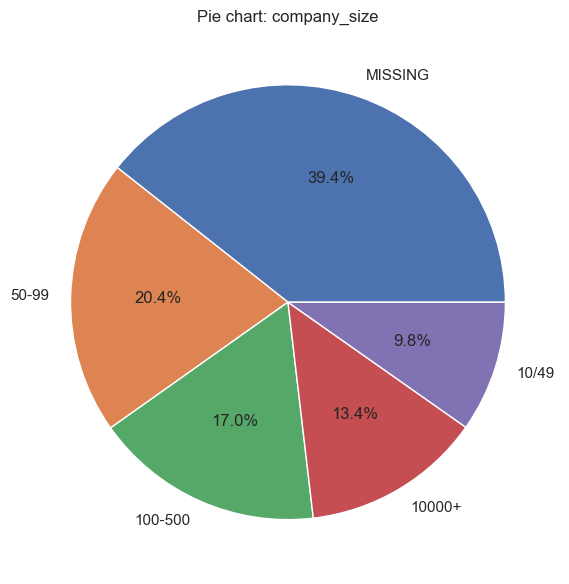


Thống kê categorical: company_type:
Pvt Ltd              :   9817 mẫu (51.24%)
MISSING              :   6140 mẫu (32.05%)
Funded Startup       :   1001 mẫu ( 5.22%)
Public Sector        :    955 mẫu ( 4.98%)
Early Stage Startup  :    603 mẫu ( 3.15%)
NGO                  :    521 mẫu ( 2.72%)
Other                :    121 mẫu ( 0.63%)



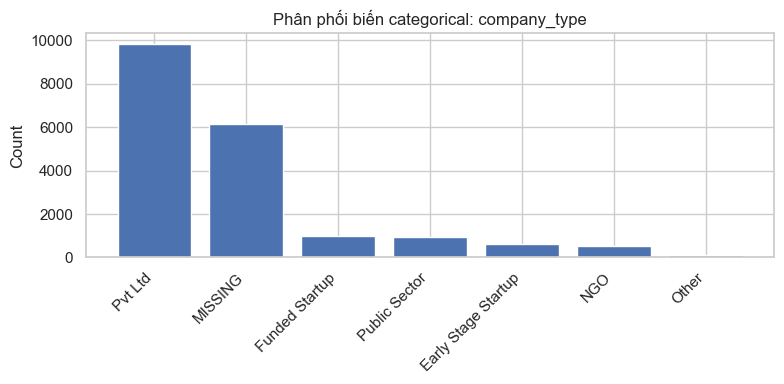


Pie chart stats: company_type:
Pvt Ltd              :   9817 mẫu (53.02%)
MISSING              :   6140 mẫu (33.16%)
Funded Startup       :   1001 mẫu ( 5.41%)
Public Sector        :    955 mẫu ( 5.16%)
Early Stage Startup  :    603 mẫu ( 3.26%)



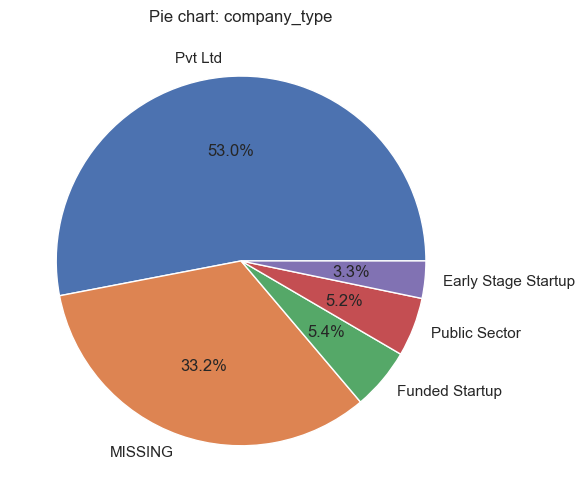


Thống kê categorical: enrolled_university:
no_enrollment        :  13817 mẫu (72.12%)
Full time course     :   3757 mẫu (19.61%)
Part time course     :   1198 mẫu ( 6.25%)
MISSING              :    386 mẫu ( 2.01%)



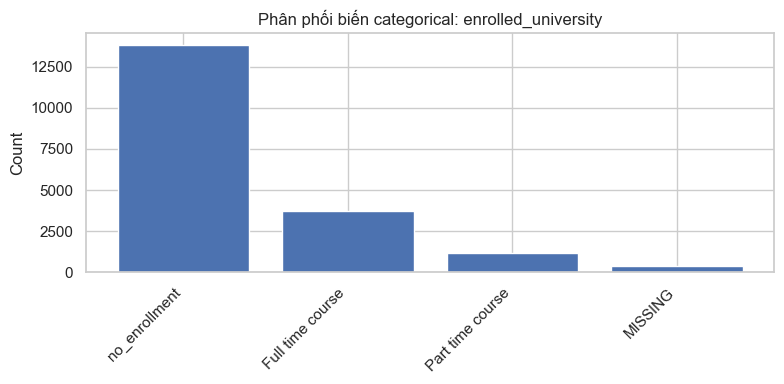


Pie chart stats: enrolled_university:
no_enrollment        :  13817 mẫu (72.12%)
Full time course     :   3757 mẫu (19.61%)
Part time course     :   1198 mẫu ( 6.25%)
MISSING              :    386 mẫu ( 2.01%)



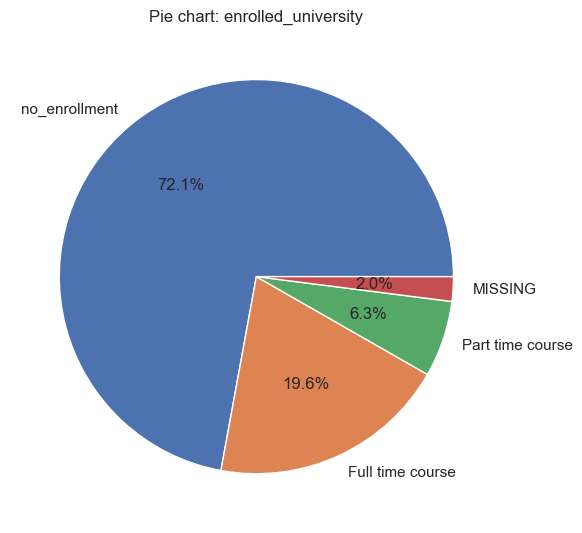


Thống kê categorical: relevent_experience:
Has relevent experience :  13792 mẫu (71.99%)
No relevent experience :   5366 mẫu (28.01%)



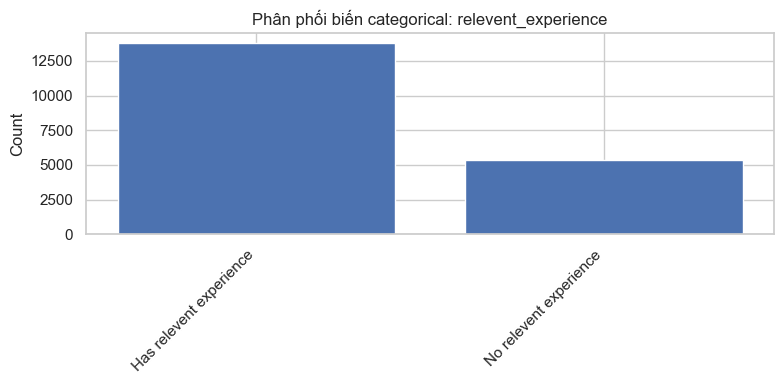


Pie chart stats: relevent_experience:
Has relevent experience :  13792 mẫu (71.99%)
No relevent experience :   5366 mẫu (28.01%)



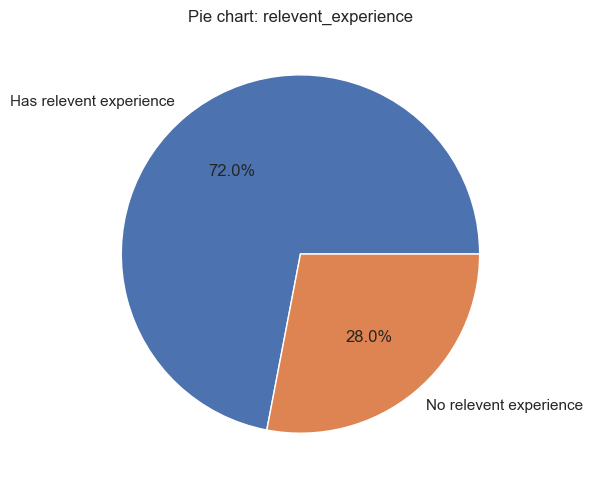


Thống kê categorical: city (top 10):
city_103             :   4355 mẫu (34.30%)
city_21              :   2702 mẫu (21.28%)
city_16              :   1533 mẫu (12.07%)
city_114             :   1336 mẫu (10.52%)
city_160             :    845 mẫu ( 6.65%)
city_136             :    586 mẫu ( 4.61%)
city_67              :    431 mẫu ( 3.39%)
city_75              :    305 mẫu ( 2.40%)
city_102             :    304 mẫu ( 2.39%)
city_104             :    301 mẫu ( 2.37%)



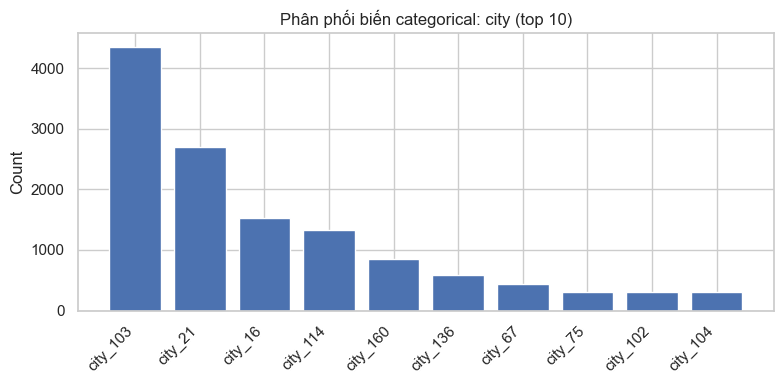


Pie chart stats: city (top 10):
city_103             :   4355 mẫu (34.30%)
city_21              :   2702 mẫu (21.28%)
city_16              :   1533 mẫu (12.07%)
city_114             :   1336 mẫu (10.52%)
city_160             :    845 mẫu ( 6.65%)
city_136             :    586 mẫu ( 4.61%)
city_67              :    431 mẫu ( 3.39%)
city_75              :    305 mẫu ( 2.40%)
city_102             :    304 mẫu ( 2.39%)
city_104             :    301 mẫu ( 2.37%)



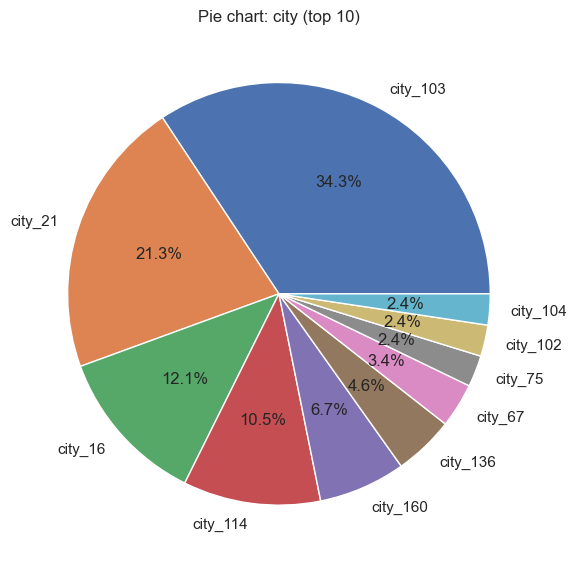

In [19]:
categorical_to_plot = [
    "gender",
    "education_level",
    "major_discipline",
    "company_size",
    "company_type",
    "enrolled_university",
    "relevent_experience",
]

for col_name in categorical_to_plot:
    col_data = get_col(col_name)
    plot_categorical_distribution(col_data, col_name)
    plot_pie(col_data, col_name, top_k=5)

city_col = get_col("city")
plot_categorical_distribution(city_col, "city (top 10)", top_k=10)
plot_pie(city_col, "city (top 10)", top_k=10)

## IV. Mối quan hệ giữa các feature với `target`

Trong phần này, ta phân tích xem các đặc trưng (feature) liên quan thế nào đến
khả năng ứng viên muốn thay đổi công việc (`target = 1`).

Ta chia làm 2 nhóm:

### Nhóm 1: Categorical vs `target`

Với mỗi biến categorical quan trọng, ta sẽ:

- Nhóm dữ liệu theo từng category.
- Tính **tỷ lệ `target = 1`** trong mỗi nhóm.
- Vẽ bar chart (`plot_target_rate_by_category`) để trực quan hóa.

Phần này giúp trả lời các câu hỏi như:

- Ứng viên có **kinh nghiệm liên quan** (`relevent_experience`) có xu hướng đổi job
  nhiều hơn người **chưa có kinh nghiệm** không?
- **Trình độ học vấn** (`education_level`) ảnh hưởng thế nào đến khả năng đổi job?
- **Ngành học / chuyên ngành** (`major_discipline`) có tạo ra sự khác biệt đáng kể
  về tỷ lệ đổi việc không?
- Một số đặc trưng khác như `gender`, `company_size`, `company_type` có tác động gì
  đến xu hướng đổi job?

### Nhóm 2: Numeric vs `target`

Với các biến numeric, ta sẽ:

- Dùng `boxplot_numeric_by_target`:
  - So sánh **phân phối**, **median** và **độ phân tán** giữa hai nhóm
    `target = 0` (không đổi job) và `target = 1` (muốn đổi job).
- Dùng `plot_hist_overlay_by_target`:
  - Vẽ **histogram overlay** của hai nhóm trên cùng một trục để so sánh trực quan.

Phần này giúp trả lời các câu hỏi như:

- `training_hours` (số giờ training) có khác biệt rõ rệt giữa người đổi job
  và không đổi job hay không?
- `experience` (số năm kinh nghiệm) ảnh hưởng thế nào đến khả năng đổi việc?
- `city_development_index` (chỉ số phát triển của thành phố) có mối liên hệ gì
  với xu hướng đổi job (người ở thành phố phát triển cao có dễ đổi việc hơn không)?

Kết quả phân tích ở phần này sẽ là cơ sở quan trọng cho việc:
- Chọn feature quan trọng,
- Thiết kế đặc trưng (feature engineering),
- Và giải thích mô hình Logistic Regression ở các bước sau.

---

### **Nhóm 1: Categorical vs `target`**


Tỷ lệ target=1 theo gender:
MISSING              | n=4508 | rate=0.308
Female               | n=1238 | rate=0.263
Other                | n= 191 | rate=0.262
Male                 | n=13221 | rate=0.228



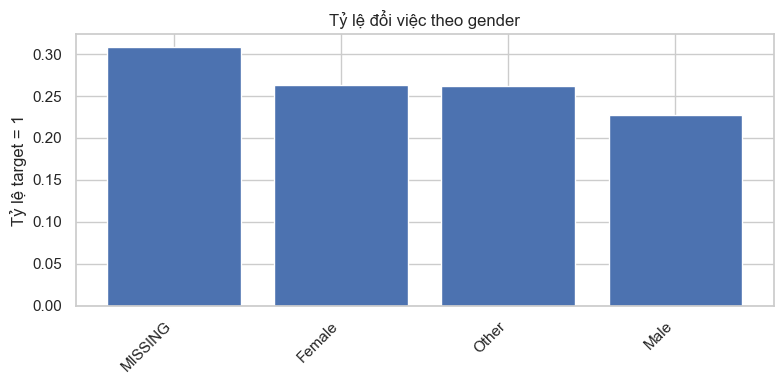


Tỷ lệ target=1 theo relevent_experience:
No relevent experience | n=5366 | rate=0.338
Has relevent experience | n=13792 | rate=0.215



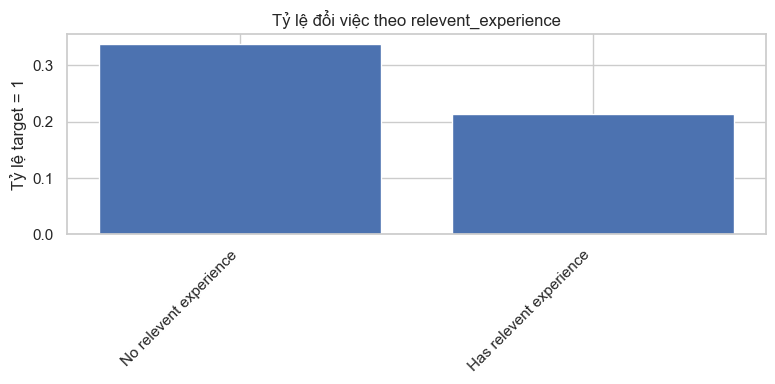


Tỷ lệ target=1 theo enrolled_university:
Full time course     | n=3757 | rate=0.381
MISSING              | n= 386 | rate=0.319
Part time course     | n=1198 | rate=0.252
no_enrollment        | n=13817 | rate=0.211



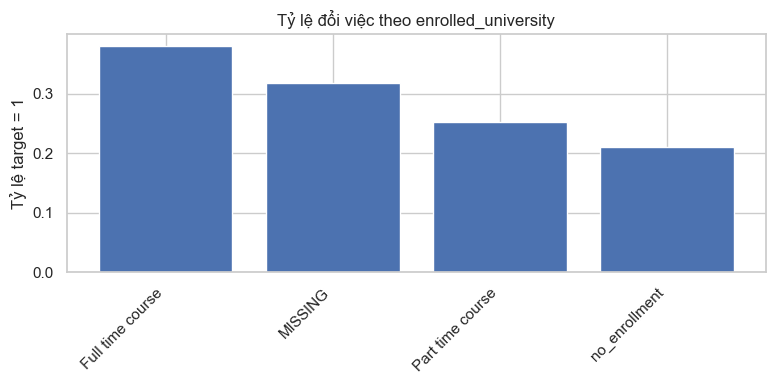


Tỷ lệ target=1 theo education_level:
Graduate             | n=11598 | rate=0.280
MISSING              | n= 460 | rate=0.226
Masters              | n=4361 | rate=0.214
High School          | n=2017 | rate=0.195
Phd                  | n= 414 | rate=0.140
Primary School       | n= 308 | rate=0.133



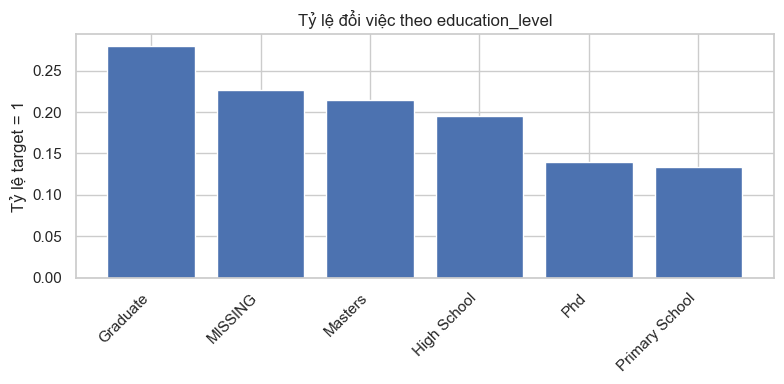


Tỷ lệ target=1 theo major_discipline:
Other                | n= 381 | rate=0.268
Business Degree      | n= 327 | rate=0.263
STEM                 | n=14492 | rate=0.262
No Major             | n= 223 | rate=0.247
Humanities           | n= 669 | rate=0.211
Arts                 | n= 253 | rate=0.209
MISSING              | n=2813 | rate=0.195



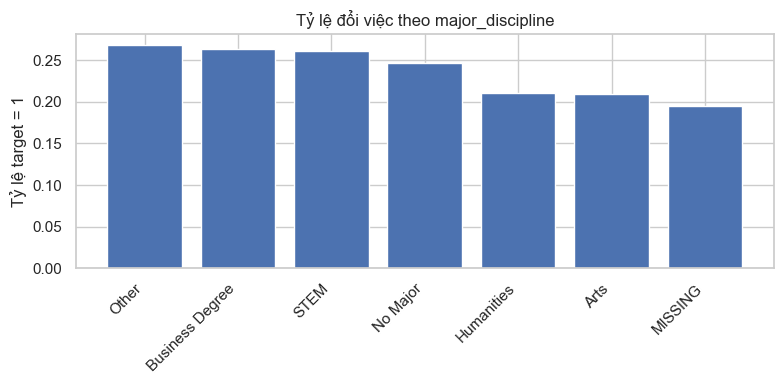


Tỷ lệ target=1 theo company_size:
MISSING              | n=5938 | rate=0.406
10/49                | n=1471 | rate=0.234
10000+               | n=2019 | rate=0.191
5000-9999            | n= 563 | rate=0.181
50-99                | n=3083 | rate=0.177
500-999              | n= 877 | rate=0.173
<10                  | n=1308 | rate=0.171
100-500              | n=2571 | rate=0.161
1000-4999            | n=1328 | rate=0.151



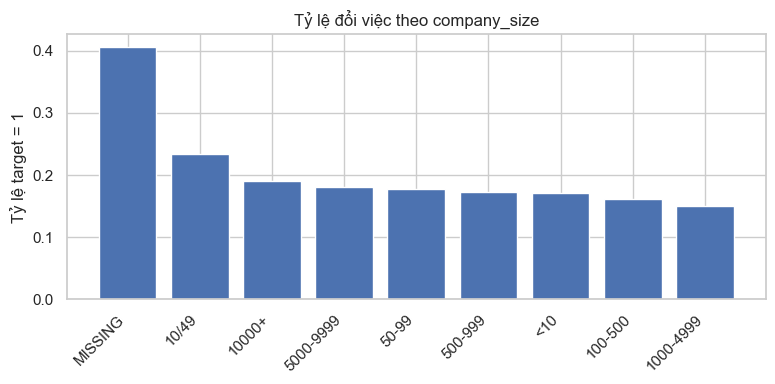


Tỷ lệ target=1 theo company_type:
MISSING              | n=6140 | rate=0.388
Other                | n= 121 | rate=0.240
Early Stage Startup  | n= 603 | rate=0.235
Public Sector        | n= 955 | rate=0.220
NGO                  | n= 521 | rate=0.186
Pvt Ltd              | n=9817 | rate=0.181
Funded Startup       | n=1001 | rate=0.140



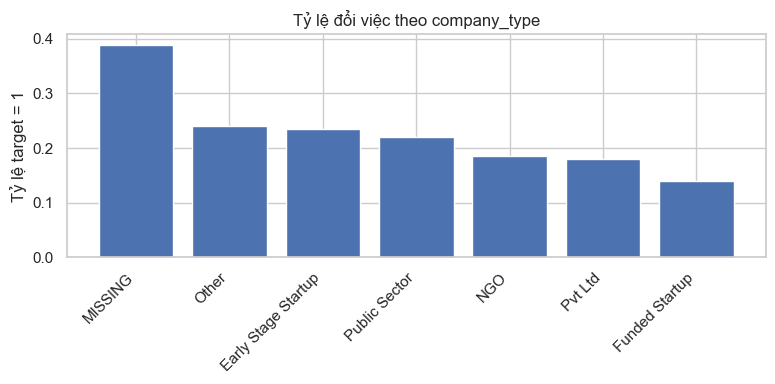

In [20]:
categorical_for_target = [
    "gender",
    "relevent_experience",
    "enrolled_university",
    "education_level",
    "major_discipline",
    "company_size",
    "company_type",
]

for col_name in categorical_for_target:
    col_data = get_col(col_name)
    plot_target_rate_by_category(col_data, target, col_name)

### **Nhóm 2: Numeric vs target**

Feature city_development_index vs target:


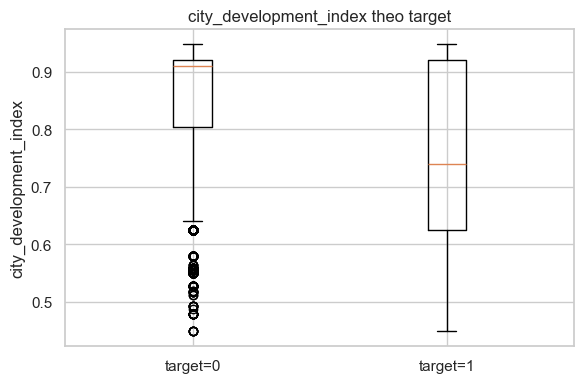

Thống kê city_development_index theo target:
target=0: mean = 0.8531394200681456 | median = 0.91 | n = 14381
target=1: mean = 0.7557194892191752 | median = 0.74 | n = 4777



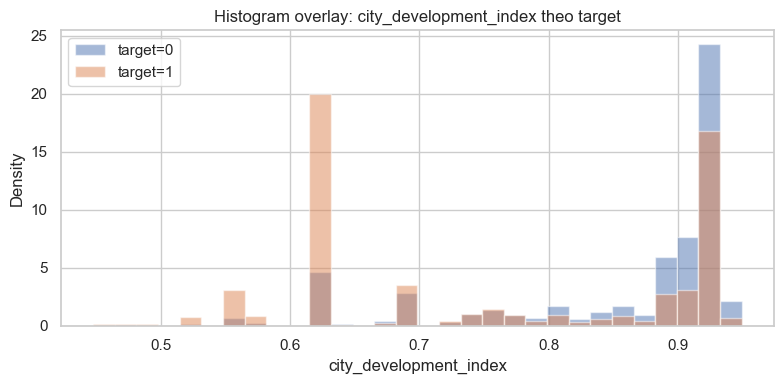


Feature training_hours vs target:


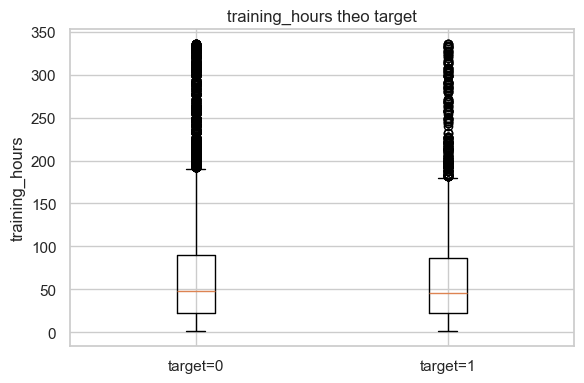

Thống kê training_hours theo target:
target=0: mean = 66.11376121271121 | median = 48.0 | n = 14381
target=1: mean = 63.11848440443793 | median = 46.0 | n = 4777



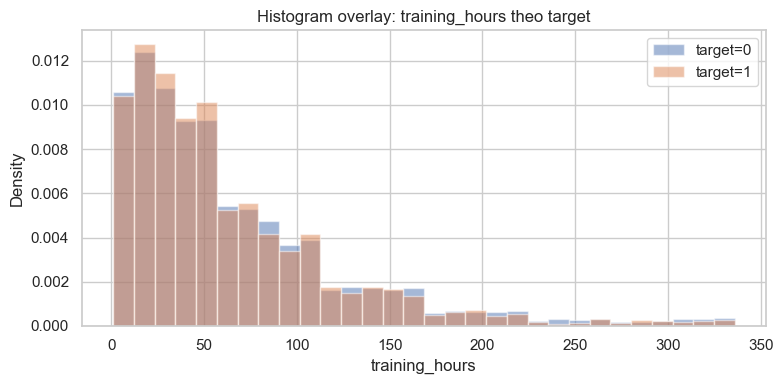


Feature experience vs target:


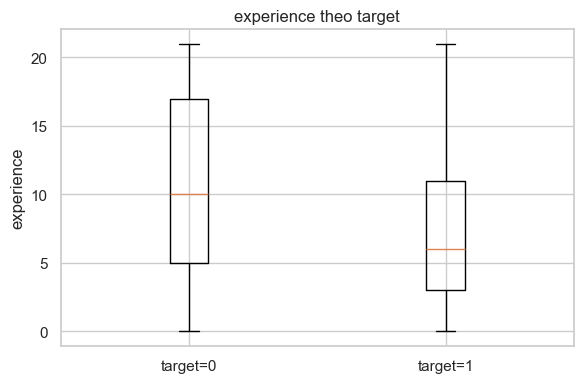

Thống kê experience theo target:
target=0: mean = 10.789734291094218 | median = 10.0 | n = 14339
target=1: mean = 8.020193521245266 | median = 6.0 | n = 4754



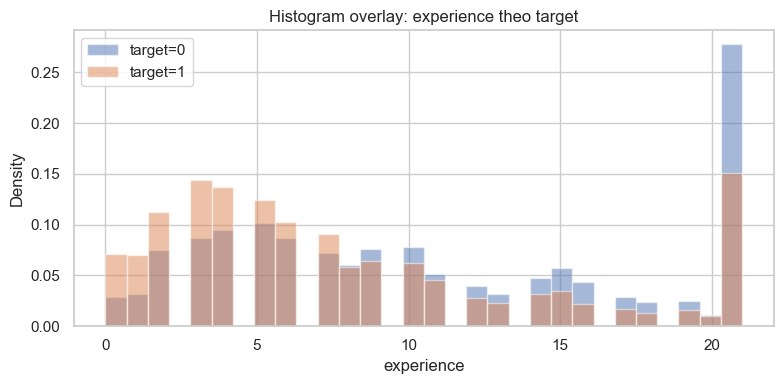


Feature last_new_job vs target:


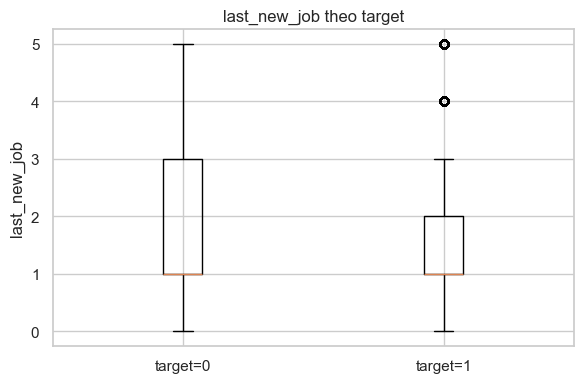

Thống kê last_new_job theo target:
target=0: mean = 2.0796485260770976 | median = 1.0 | n = 14112
target=1: mean = 1.7585983127839067 | median = 1.0 | n = 4623



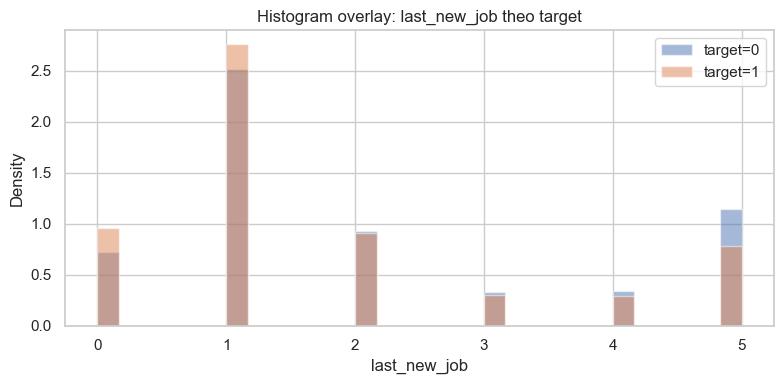

In [21]:
for name, arr in numeric_arrays.items():
    print(f"Feature {name} vs target:")
    boxplot_numeric_by_target(arr, target, name)
    plot_hist_overlay_by_target(arr, target, name, bins=30)
    print()

## V. Quan hệ giữa các biến numeric & tương quan
**Phần này sẽ:**

- Vẽ scatter plot giữa các cặp biến numeric (`plot_scatter`).
- Vẽ scatter matrix (`plot_scatter_matrix`) cho nhóm numeric.
- Tính ma trận tương quan Pearson & Spearman:
  - Dùng `np.corrcoef`.
- Vẽ heatmap (`plot_correlation_heatmap`) để xem:
  - Biến nào đồng biến / nghịch biến mạnh.
  - Có multicollinearity (các biến quá giống nhau) hay không?

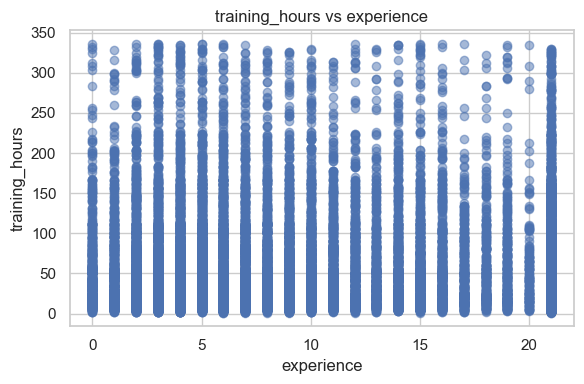

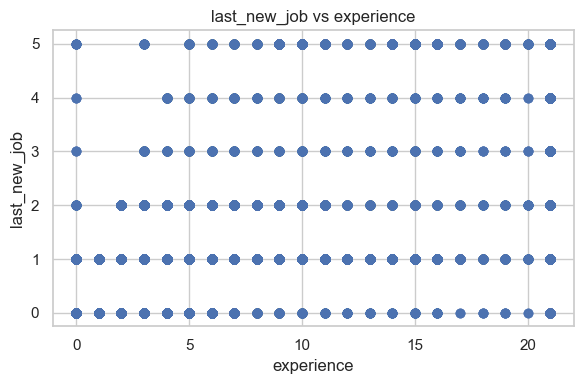

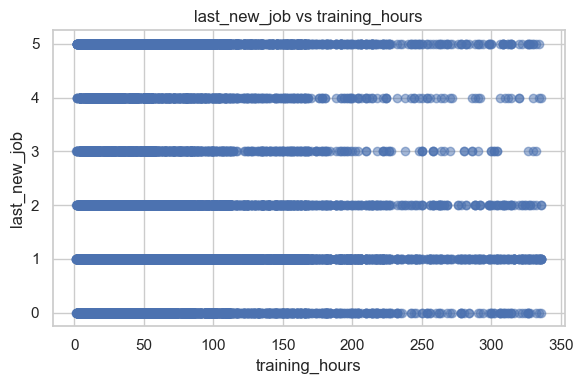

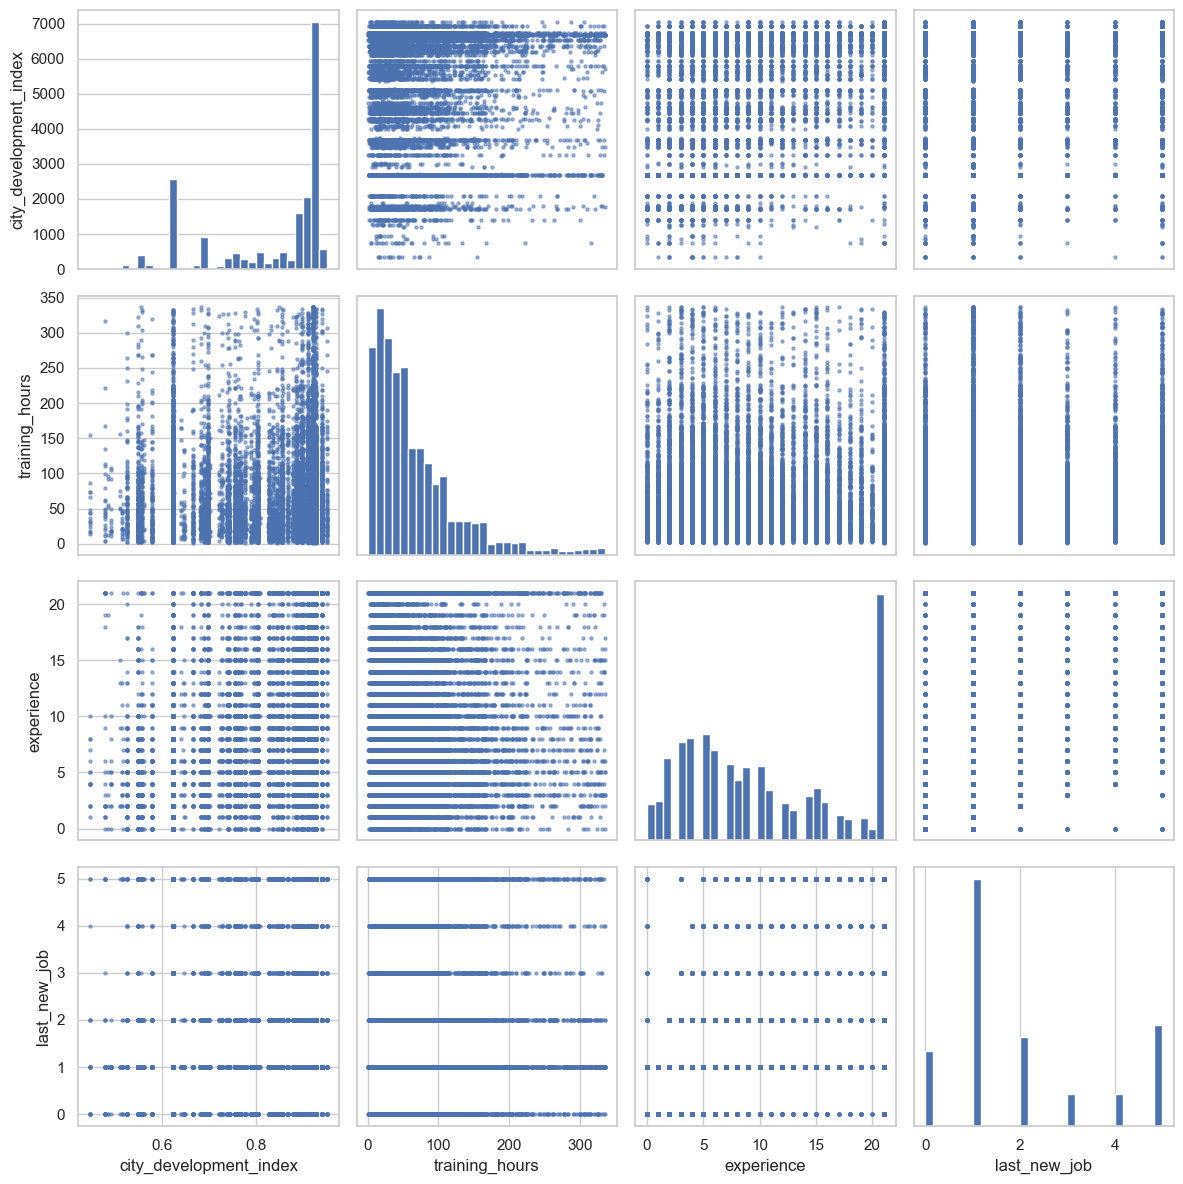

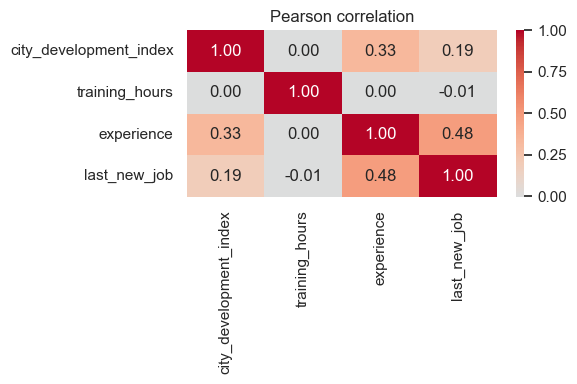

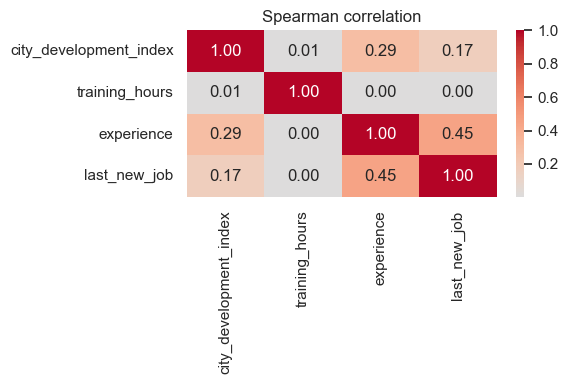

In [22]:
# Matrix numeric 
num_matrix = np.vstack([cdi, training_hours, experience, last_new_job]).T
mask_valid = ~np.isnan(num_matrix).any(axis=1)
num_matrix_clean = num_matrix[mask_valid]

feature_names = [
    "city_development_index",
    "training_hours",
    "experience",
    "last_new_job",
]

# Scatter plot đơn 
plot_scatter(experience, training_hours, "experience", "training_hours")
plot_scatter(experience, last_new_job, "experience", "last_new_job")
plot_scatter(training_hours, last_new_job, "training_hours", "last_new_job")

# Scatter matrix
plot_scatter_matrix(num_matrix_clean, feature_names)

# Pearson correlation
corr_pearson = np.corrcoef(num_matrix_clean, rowvar=False)
plot_correlation_heatmap(corr_pearson, feature_names, title="Pearson correlation")

# Spearman correlation 
ranked = np.apply_along_axis(lambda v: v.argsort().argsort(), 0, num_matrix_clean)
corr_spearman = np.corrcoef(ranked, rowvar=False)
plot_correlation_heatmap(corr_spearman, feature_names, title="Spearman correlation")

## VI. Line chart minh hoạ xu hướng
**Phần này sẽ:**

- Binning biến `experience` thành các nhóm:
  - `<=1`, `1-3`, `3-5`, `5-10`, `10-20`, `>20`.
- Tính tỷ lệ `target=1` trong mỗi nhóm.
- Sắp xếp theo thứ tự và vẽ line chart (`plot_line`) để minh hoạ xu hướng:
  - Kinh nghiệm tăng → khả năng đổi job thay đổi như thế nào?

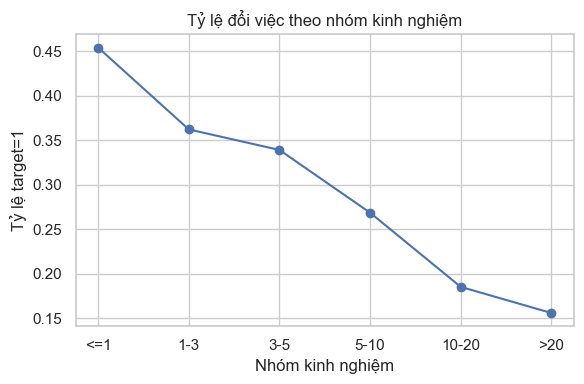

In [23]:
exp_all = experience.copy()
bins = [0, 1, 3, 5, 10, 20, 1e9]
labels = ["<=1", "1-3", "3-5", "5-10", "10-20", ">20"]

cat_exp = np.empty_like(exp_all, dtype=object)
cat_exp[:] = "missing"
    
for i in range(len(bins) - 1):
    mask = (exp_all >= bins[i]) & (exp_all < bins[i + 1])
    cat_exp[mask] = labels[i]

uniq = np.array(labels)
rates = []

for g in uniq:
    mask = (cat_exp == g)
    y = target[mask]
    y_clean = y[~np.isnan(y)]
    if y_clean.size == 0:
        rates.append(np.nan)
    else:
        rates.append(np.mean(y_clean))

plot_line(uniq, rates, "Nhóm kinh nghiệm", "Tỷ lệ target=1", "Tỷ lệ đổi việc theo nhóm kinh nghiệm")

## VII. Phân tích dữ liệu dựa trên các câu hỏi

### **Câu hỏi 1 – Các feature đơn lẻ ảnh hưởng đến khả năng đổi job thì các cụm feature có ảnh hưởng đến hay không?**

**Cụ thể**

Dựa trên các đặc trưng chính:
- `experience` (số năm kinh nghiệm),
- `last_new_job` (số năm từ lần đổi việc gần nhất),
- `training_hours` (số giờ training),
- `city_development_index` (mức độ phát triển của thành phố),

liệu có thể xây dựng được một số cụm feature với nguy cơ đổi job khác nhau không?  
Nói cách khác: *những kiểu ứng viên nào (tổ hợp kinh nghiệm – lịch sử đổi job – mức độ training – bối cảnh thành phố) có tỷ lệ muốn đổi job cao nhất?*

**Mục tiêu**

- Không chỉ phân tích từng biến riêng lẻ, mà **nhóm ứng viên theo nhiều yếu tố cùng lúc** để tạo thành các bộ feauture dễ hiểu.
- Với mỗi profile:
  - Mô tả rõ ràng đặc trưng (khoảng kinh nghiệm, khoảng last_new_job, mức training, mức CDI),
  - Tính **tỷ lệ `target = 1`** để xác định đâu là nhóm **“dễ nhảy việc”** nhất.
- Kết quả giúp doanh nghiệp biết **nên chú ý / ưu tiên nhóm ứng viên nào** trong chiến lược thu hút và giữ chân nhân sự.

**Cách tiếp cận**
1. Chia mỗi biến thành các nhóm (bins) có ý nghĩa:
   - `experience` → `≤1 năm`, `1–3 năm`, `3–7 năm`, `>7 năm`,
   - `last_new_job` → `≤1 năm`, `1–2 năm`, `2–4 năm`, `>4 năm`,
   - `training_hours` → chia theo các mức `Thấp`, `Trung bình`, `Cao`, `Rất cao` (dựa trên các quantile),
   - `city_development_index` → `CDI thấp`, `CDI trung bình`, `CDI cao`.
2. Định nghĩa “bộ feature” là một tổ hợp 4 chiều:
   (nhóm kinh nghiệm, nhóm last_new_job, nhóm training, nhóm CDI)
3. Với mỗi bộ feature:
   - Đếm số ứng viên thuộc bộ feauture đó,
   - Tính tỷ lệ `target=1` trong bộ feauture.


Q1: Top 6 risk profiles có tỷ lệ target=1 cao nhất (chỉ xét profile có ít nhất 50 mẫu)
ID   Kinh nghiệm     Last_new_job    Training     CDI              Số mẫu     Tỷ lệ target=1
--------------------------------------------------------------------------------------------------------------
P01  3–7 năm         ≤1 năm          Trung bình   CDI thấp             60              61.7%
P02  ≤1 năm          ≤1 năm          Cao          CDI trung bình      113              60.2%
P03  3–7 năm         ≤1 năm          Rất cao      CDI thấp             54              59.3%
P04  3–7 năm         ≤1 năm          Cao          CDI thấp             53              58.5%
P05  ≤1 năm          ≤1 năm          Rất cao      CDI trung bình       97              56.7%
P06  ≤1 năm          ≤1 năm          Thấp         CDI trung bình      125              54.4%


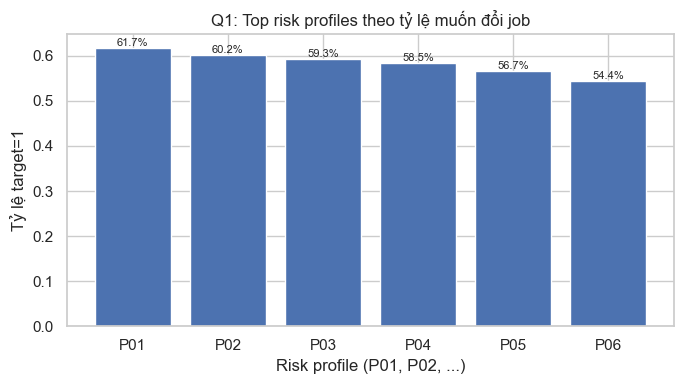

In [24]:
visualize_q1_risk_profiles(experience, last_new_job, training_hours, cdi, target)

#### **Nhận xét kết quả**
- **Điểm chung lớn nhất** của tất cả các bộ feature khả năng cao là:
  - Đều có `last_new_job ≤ 1 năm` → những ứng viên **mới đổi job gần đây** lại chính là nhóm có **xác suất muốn tiếp tục đổi job** cao nhất.
  - Điều này cho thấy lịch sử “last_new_job” là một **tín hiệu khả năng mạnh**.

- Có hai nhóm nổi bật:

  1. **Mid-level, CDI thấp, mới đổi job:**
     - Các bộ feature P01, P03, P04 đều có:
       - `experience` từ **3–7 năm**,
       - `last_new_job ≤ 1 năm`,
       - `CDI thấp`.
     - Tỷ lệ `target=1` dao động khoảng **58–62%**.
     - Đây là nhóm ứng viên đã có kinh nghiệm nhưng đang ở thành phố kém phát triển, có thể **chưa hài lòng với cơ hội hiện tại** và tiếp tục tìm chỗ tốt hơn.

  2. **Junior, CDI trung bình, mới đổi job:**
     - Các bộ feature P02, P05, P06 đều có:
       - `experience ≤ 1 năm`,
       - `last_new_job ≤ 1 năm`,
       - `CDI trung bình`.
     - Tỷ lệ `target=1` trong khoảng **54–60%**.
     - Nhóm này có vẻ là **ứng viên rất trẻ, linh hoạt**, sẵn sàng đổi việc để thử nghiệm môi trường mới.

- **Training không phải là thứ quyết định:**
  - Trong Top 6 xuất hiện đầy đủ các mức `Thấp`, `Trung bình`, `Cao`, `Rất cao`.
  - Điều này cho thấy chỉ riêng việc tăng `training_hours` **không đủ** để giảm ý định đổi job:
    - Có bộ feature training rất cao nhưng vẫn thuộc nhóm khả năng cao (P03, P05),
    - Lẫn bộ feature training thấp nhưng khả năng vẫn lớn (P06).

- **Yếu tố city_development_index (CDI) cũng tương đối ảnh hưởng:**
  - Nhóm mid-level ở **CDI thấp** (P01, P03, P04) có khả năng cao,
  - Nhóm junior ở **CDI trung bình** (P02, P05, P06) cũng có khả năng đáng kể.
  - Do đó, khi xây dựng chiến lược giữ chân nhân sự, cần xem xét kết hợp **kinh nghiệm cá nhân** và **mức độ phát triển khu vực** thay vì nhìn từng yếu tố riêng lẻ.

**Kết luận:**  
Việc phân tích theo 'bộ feature' cho thấy có thể nhận diện được những **thể loại ứng viên** (về kinh nghiệm, lịch sử đổi job, mức training, CDI) có **nguy cơ đổi job cao**. Đây là cơ sở để doanh nghiệp **ưu tiên giữ chân** một số nhóm nhất định thay vì áp dụng cùng một chính sách cho toàn bộ ứng viên/nhân viên.

---

### **Câu hỏi 2 – Có “điểm tới hạn” cho số giờ training không?**

**Cụ thể**

Khi tăng `training_hours`, **tỷ lệ ứng viên muốn đổi job (`target=1`) thay đổi thế nào**?

- Training càng nhiều → càng ít muốn đổi job?
- Hay training quá nhiều lại khiến ứng viên “nâng skill rồi nhảy”?
- Có tồn tại **khoảng training tối ưu** (vượt quá thì hiệu ứng giữ chân giảm hoặc đảo chiều)?

**Mục tiêu**

- Tìm hiểu mối quan hệ **phi tuyến** giữa số giờ training và ý định đổi job.
- Gợi ý cho doanh nghiệp:
  - Đào tạo bao nhiêu là hợp lý,
  - Tránh lãng phí tài nguyên cho những giờ training không còn tạo thêm giá trị giữ chân.

**Cách tiếp cận**
- Chia `training_hours` thành nhiều khoảng (bins),
- Tính **tỷ lệ `target=1` trong từng khoảng** và vẽ line chart,
- Kết hợp thêm boxplot / histogram overlay `training_hours` theo `target`.
- Trong notebook, câu hỏi này được minh họa bằng:
  - `visualize_q2_training_hours_effect(training_hours, target)`


Q2: Tỷ lệ target=1 theo các khoảng training_hours:
[0, 10)        : n =  1486, rate = 0.252
[10, 20)       : n =  2363, rate = 0.251
[20, 40)       : n =  4242, rate = 0.255
[40, 80)       : n =  5483, rate = 0.258
[80, 160)      : n =  4080, rate = 0.243
[160, 500)     : n =  1504, rate = 0.217


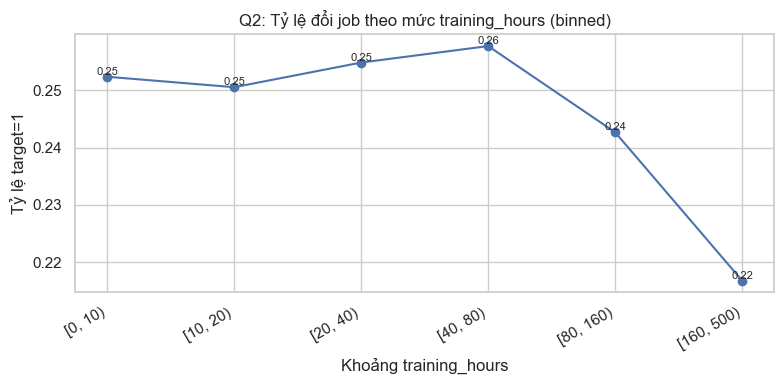

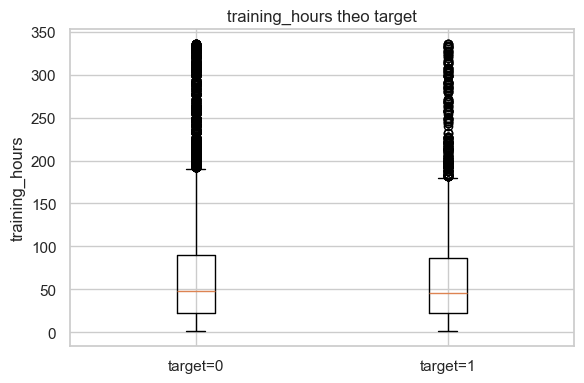

Thống kê training_hours theo target:
target=0: mean = 66.11376121271121 | median = 48.0 | n = 14381
target=1: mean = 63.11848440443793 | median = 46.0 | n = 4777



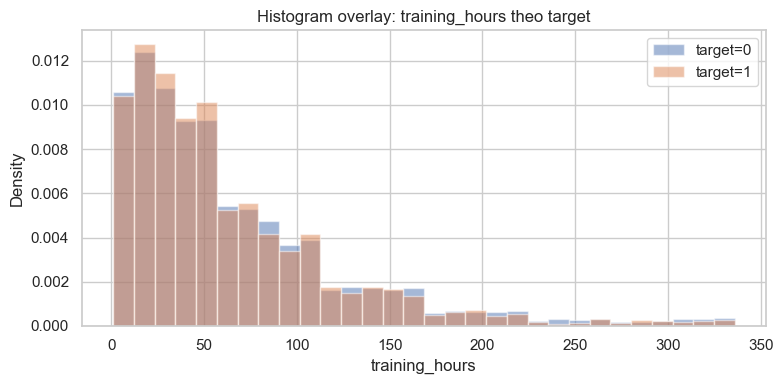

In [25]:
visualize_q2_training_hours_effect(training_hours, target)

#### **Nhận xét kết quả**

**1. Pattern tổng quát từ line chart (tỷ lệ target=1 theo bin)**  
- Trong khoảng **0–80 giờ training**, tỷ lệ `target=1` dao động khá hẹp quanh **25–26%**, gần như **không có xu hướng tăng/giảm rõ rệt**.  
- Sau mốc khoảng **80 giờ**, tỷ lệ bắt đầu **giảm nhẹ**:
  - từ ~25.8% xuống 24.3% cho `[80, 160)`,
  - và giảm rõ hơn xuống 21.7% cho `[160, 500)`.  
→ Nhìn chung có một **xu hướng giảm nhẹ** ý định đổi job ở nhóm được training rất nhiều, nhưng biên độ chênh lệch chỉ khoảng **4–5 điểm phần trăm**, nên đây **không phải một “bước ngoặt” mạnh**.

**2. So sánh phân phối `training_hours` theo target (boxplot)**  
- Hai boxplot `training_hours` cho `target=0` và `target=1`:
  - **Median nằm khá gần nhau**,  
  - IQR và dạng phân bố tương đối giống nhau,
  - Nhìn kỹ có thể thấy nhóm `target=1` hơi thiên nhẹ về phía các giá trị training thấp hơn (đáy hộp và phần phân vị dưới hơi “dịch” sang trái).  
→ Điều này gợi ý một xu hướng **ứng viên được training ít hoặc vừa đủ có khuynh hướng muốn đổi job nhỉnh hơn một chút** so với nhóm được training nhiều hơn, nhưng khác biệt không quá mạnh.

**3. Histogram overlay theo target**  
- Hai đường phân bố (density) của `target=0` và `target=1` có rất nhiều cột **chồng lên nhau**, chứng tỏ phân phối tổng thể khá giống.  
- Ở đoạn **0–50 giờ**, mật độ của `target=1` thường nhỉnh hơn hoặc “đè” nhẹ lên `target=0`, trong khi ở các vùng training cao hơn (≈ 80+ giờ) hai nhóm gần như hòa lẫn.  
→ Kết quả này củng cố quan sát: **nhóm đổi job xuất hiện tương đối nhiều ở các mức training thấp–trung bình**, còn ở vùng training rất cao thì sự khác biệt giữa hai nhóm hầu như mờ nhạt.

**4. Kết luận**  
- Dữ liệu **không cho thấy một “điểm tới hạn” rõ ràng** mà tại đó việc tăng số giờ training làm đảo chiều mạnh ý định đổi job. Nhưng có thể thấy thì số giờ training càng nhiều thì tỷ lệ có thể sẽ giữ chân được ứng viên càng cao.
- Ở vùng **0–80 giờ**, tỷ lệ `target=1` gần như giữ nguyên; ở vùng **training rất cao (≥160 giờ)**, tỷ lệ này có xu hướng giảm xuống khoảng **21–22%**, nhưng chênh lệch so với các nhóm khác không quá lớn.  
- Do đó:
  - `training_hours` **không phải là feature quyết định mạnh** cho hành vi đổi job nếu xét một mình,
  - Việc training quá ít cũng không giúp giữ chân nhân sự; thậm chí nhóm training thấp–trung bình còn xuất hiện nhiều ứng viên có ý định đổi job hơn,
  - Biến này nên được xem như **một yếu tố bổ sung**, kết hợp với các đặc trưng khác (kinh nghiệm, thành phố, loại khoá học, mức lương, v.v.) thay vì trông chờ “cứ tăng số giờ training là nhân viên sẽ ở lại” vì không mang lại quá nhiều hiệu quả.


#